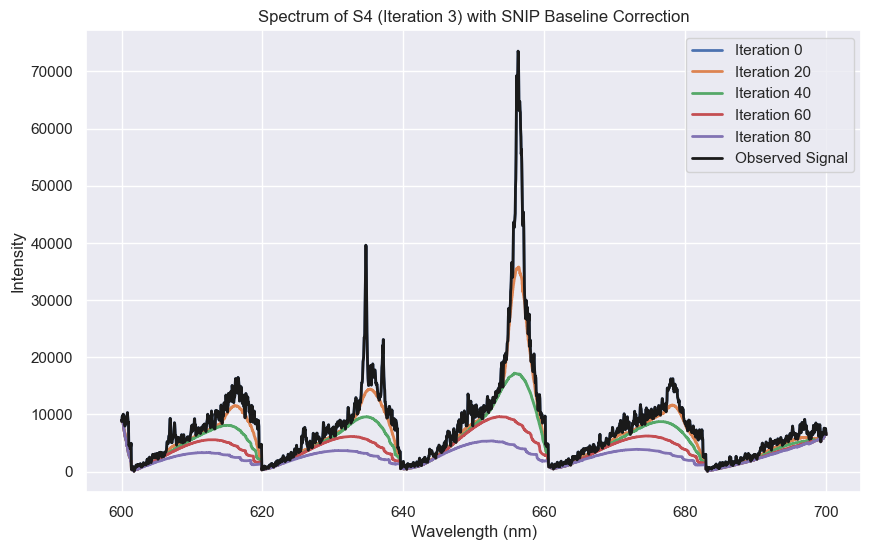

In [13]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sympy import rotations


# Fungsi untuk mengambil spektrum serta kedalaman, lokasi, dan titik lokasi (location_point) dari database
def get_spectrum_with_metadata(db_path, sample_name, iteration):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Ambil spektrum serta kedalaman, lokasi, dan titik lokasi (location_point)
    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name, iteration))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan titik lokasi (location_point)
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk menerapkan SNIP minimum filter
def min_filt(S_LLS, m):
    """Applies the SNIP minimum filter for baseline correction"""
    S_LLS_filt = np.copy(S_LLS)
    for i in range(m, len(S_LLS) - m):
        S_LLS_filt[i] = min(S_LLS[i], (S_LLS[i - m] + S_LLS[i + m]) / 2)
    return S_LLS_filt

# Fungsi untuk menampilkan spektrum dengan baseline yang dikoreksi menggunakan SNIP dan batas panjang gelombang
def plot_spectrum_with_snip_baseline(db_path, sample_name, iteration, num_iterations=100, plot_interval=20, wavelength_min=None, wavelength_max=None):
    wavelengths, intensities, depth, location, location_point = get_spectrum_with_metadata(db_path, sample_name, iteration)

    if len(wavelengths) == 0:
        return  # Tidak ada data yang ditemukan

    # Terapkan SNIP filter untuk beberapa iterasi dan tampilkan plot setiap interval
    S_LLS_filt = np.copy(intensities)

    # Filter data berdasarkan batas panjang gelombang
    if wavelength_min is not None and wavelength_max is not None:
        mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]
        S_LLS_filt = S_LLS_filt[mask]

    plt.figure(figsize=(10, 6))
    for m in range(num_iterations):
        S_LLS_filt = min_filt(S_LLS_filt, m)
        # Plot setiap plot_interval iterasi
        if (m % plot_interval) == 0:
            plt.plot(wavelengths, S_LLS_filt, '-', label=f'Iteration {m}', lw=2)

    # Plot sinyal asli
    plt.plot(wavelengths, intensities, 'k-', label='Observed Signal', lw=2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f'Spectrum of {sample_name} (Iteration {iteration}) with SNIP Baseline Correction')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Path ke database
db_path = 'tanah_vulkanik.db'

# Contoh plot spektrum dari salah satu sampel, misalnya S4 iterasi 3 dengan SNIP baseline correction dan batas panjang gelombang tertentu
sample_name = 'S4'
iteration = 3
wavelength_min = 600  # Batas panjang gelombang minimum
wavelength_max = 700  # Batas panjang gelombang maksimum

# Plot spektrum dengan baseline correction menggunakan SNIP dan batas panjang gelombang
plot_spectrum_with_snip_baseline(db_path, sample_name, iteration, num_iterations=100, plot_interval=20, wavelength_min=wavelength_min, wavelength_max=wavelength_max)

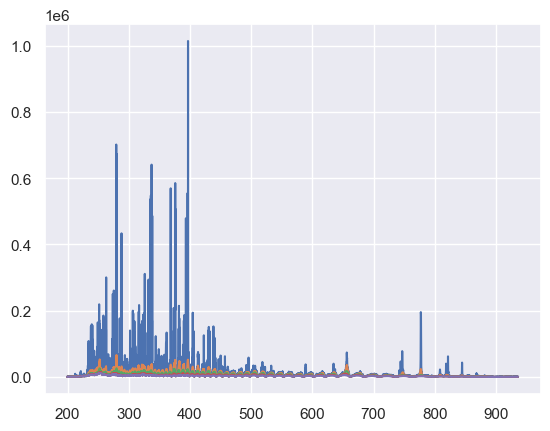

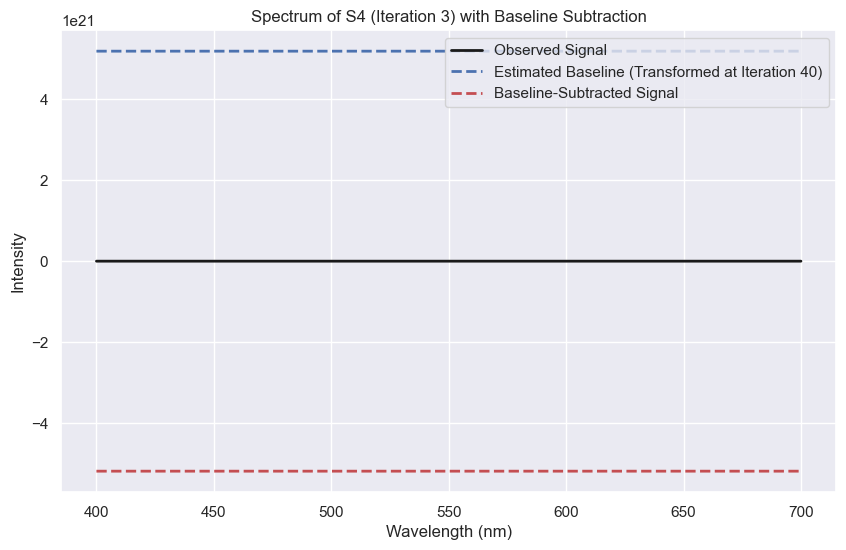

In [9]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum serta kedalaman, lokasi, dan titik lokasi (location_point) dari database
def get_spectrum_with_metadata(db_path, sample_name, iteration):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Ambil spektrum serta kedalaman, lokasi, dan titik lokasi (location_point)
    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name, iteration))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan titik lokasi (location_point)
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk menerapkan SNIP minimum filter
def min_filt(S_LLS, m):
    """Applies the SNIP minimum filter for baseline correction"""
    S_LLS_filt = np.copy(S_LLS)
    for i in range(m, len(S_LLS) - m):
        S_LLS_filt[i] = min(S_LLS[i], (S_LLS[i - m] + S_LLS[i + m]) / 2)
    return S_LLS_filt

# Fungsi untuk menampilkan spektrum dengan baseline yang dikoreksi menggunakan SNIP dan batas panjang gelombang
def plot_spectrum_with_baseline_subtraction(db_path, sample_name, iteration, num_iterations=100, plot_interval=20, transform_iteration=40, wavelength_min=None, wavelength_max=None):
    wavelengths, intensities, depth, location, location_point = get_spectrum_with_metadata(db_path, sample_name, iteration)

    if len(wavelengths) == 0:
        return  # Tidak ada data yang ditemukan

    # Terapkan SNIP filter untuk beberapa iterasi dan simpan hasil akhir sebagai baseline
    S_LLS_filt = np.copy(intensities)
    S_prime = None  # Inisialisasi baseline hasil transformasi

    for m in range(num_iterations):
        S_LLS_filt = min_filt(S_LLS_filt, m)

        # Lakukan transformasi invers pada iterasi ke-40
        if m == transform_iteration:
            # Clipping lebih ketat untuk menghindari overflow
            S_LLS_filt_clipped = np.clip(S_LLS_filt, -50, 50)
            # Gunakan transformasi eksponensial sederhana untuk menghindari overflow
            S_prime = np.exp(S_LLS_filt_clipped) - 1

        # Plot baseline setiap beberapa iterasi untuk visualisasi
        if m % plot_interval == 0 or m == transform_iteration:
            plt.plot(wavelengths, S_LLS_filt, label=f'Iteration {m}')

    # Hitung sinyal yang telah dikurangi baseline hanya jika `S_prime` tersedia
    if S_prime is not None:
        S_subtracted = intensities - S_prime

        # Filter data berdasarkan batas panjang gelombang
        if wavelength_min is not None and wavelength_max is not None:
            mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
            wavelengths = wavelengths[mask]
            intensities = intensities[mask]
            S_prime = S_prime[mask]
            S_subtracted = S_subtracted[mask]

        # Plot sinyal asli, baseline yang dikoreksi, dan sinyal yang telah dikurangi baseline
        plt.figure(figsize=(10, 6))
        plt.plot(wavelengths, intensities, 'k-', lw=2, label='Observed Signal')
        plt.plot(wavelengths, S_prime, 'b--', lw=2, label=f'Estimated Baseline (Transformed at Iteration {transform_iteration})')
        plt.plot(wavelengths, S_subtracted, 'r--', lw=2, label='Baseline-Subtracted Signal')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity')
        plt.title(f'Spectrum of {sample_name} (Iteration {iteration}) with Baseline Subtraction')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    else:
        print("Baseline transformation was not applied.")

# Path ke database
db_path = 'tanah_vulkanik.db'

# Contoh plot spektrum dari salah satu sampel, misalnya S4 iterasi 3 dengan SNIP baseline correction dan batas panjang gelombang tertentu
sample_name = 'S4'
iteration = 3
wavelength_min = 400  # Batas panjang gelombang minimum
wavelength_max = 700  # Batas panjang gelombang maksimum

# Plot spektrum dengan baseline correction menggunakan SNIP, transformasi invers pada iterasi ke-40, dan baseline subtraction
plot_spectrum_with_baseline_subtraction(db_path, sample_name, iteration, num_iterations=100, plot_interval=20, transform_iteration=40, wavelength_min=wavelength_min, wavelength_max=wavelength_max)

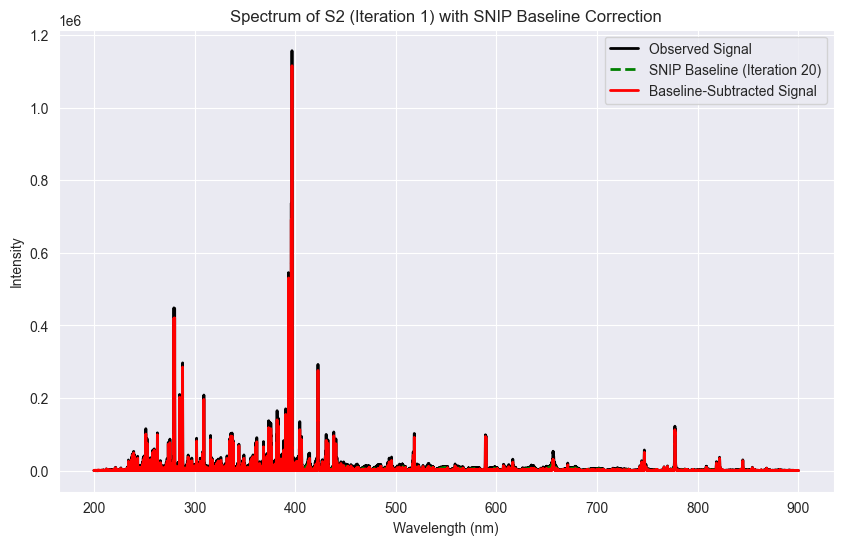

Baseline-subtracted signal (S_subtracted):
[143.34610246 130.58279611 127.83693587 ...  19.092058     0.
   0.        ]


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fungsi untuk mengambil data spektrum dari database
def get_spectrum_from_db(db_path, sample_name, iteration):
    conn = sqlite3.connect(db_path)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    df = pd.read_sql_query(query, conn, params=(sample_name, iteration))
    conn.close()
    return df['wavelength'].values, df['intensity'].values

# Fungsi SNIP untuk baseline correction
def snip_baseline_correction(signal, num_iterations=40):
    """
    Applies SNIP baseline correction to the signal.
    
    Parameters:
    signal : array_like
        Input signal for baseline correction.
    num_iterations : int
        Number of iterations for the SNIP algorithm.

    Returns:
    baseline : array_like
        Estimated baseline after SNIP correction.
    """
    L = len(signal)
    baseline = np.copy(signal)
    for m in range(num_iterations):
        for i in range(L - m - 1):
            baseline[i] = min(baseline[i], (baseline[i + m] + baseline[i - m]) / 2)
    return baseline

# Fungsi untuk plot spektrum dengan baseline correction menggunakan SNIP
def plot_spectrum_with_snip_baseline(db_path, sample_name, iteration, num_iterations=40, wavelength_min=None, wavelength_max=None):
    # Dapatkan data spektrum dari database
    wavelengths, intensities = get_spectrum_from_db(db_path, sample_name, iteration)
    
    # Filter data berdasarkan batas panjang gelombang jika disediakan
    if wavelength_min is not None and wavelength_max is not None:
        mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]

    # Terapkan SNIP baseline correction pada iterasi yang ditentukan
    baseline = snip_baseline_correction(intensities, num_iterations=num_iterations)
    corrected_signal = intensities - baseline  # Ini adalah S_subtracted
    
    # Plot hasil
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, 'k-', lw=2, label='Observed Signal')
    plt.plot(wavelengths, baseline, 'g--', lw=2, label=f'SNIP Baseline (Iteration {num_iterations})')
    plt.plot(wavelengths, corrected_signal, 'r-', lw=2, label='Baseline-Subtracted Signal')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f'Spectrum of {sample_name} (Iteration {iteration}) with SNIP Baseline Correction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Kembalikan sinyal yang sudah dikurangi baseline
    return wavelengths, corrected_signal

# Path ke database
db_path = 'tanah_vulkanik.db'

# Contoh penggunaan untuk sampel S4 iterasi 3 dengan SNIP baseline correction pada iterasi ke-40
sample_name = 'S2'
iteration = 1
wavelength_min = 200 # Batas panjang gelombang minimum
wavelength_max = 900  # Batas panjang gelombang maksimum

# Plot spektrum dan dapatkan S_subtracted
wavelengths, S_subtracted = plot_spectrum_with_snip_baseline(
    db_path, sample_name, iteration, num_iterations=20, wavelength_min=wavelength_min, wavelength_max=wavelength_max
)

# Sekarang S_subtracted tersedia untuk digunakan lebih lanjut
print("Baseline-subtracted signal (S_subtracted):")
print(S_subtracted)

Jumlah puncak yang ditemukan: 671


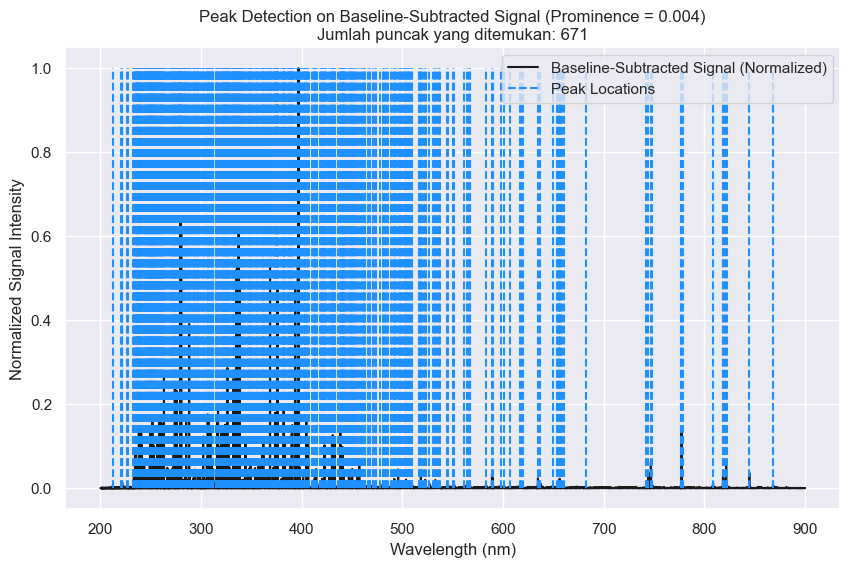

In [70]:
import scipy.signal
import matplotlib.pyplot as plt

# Asumsikan S_subtracted berisi hasil baseline-subtracted signal dan wavelengths berisi panjang gelombang yang sesuai

# Normalisasi sinyal yang sudah dikurangi baseline
signal_norm = (S_subtracted - S_subtracted.min()) / (S_subtracted.max() - S_subtracted.min())

# Deteksi puncak dengan filter prominence
prominence_value = 0.004  # Anda bisa menyesuaikan ini sesuai kebutuhan
peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=prominence_value)

# Hitung jumlah puncak yang ditemukan
num_peaks = len(peak_locations)
print(f"Jumlah puncak yang ditemukan: {num_peaks}")

# Plot sinyal yang sudah dikurangi baseline dan lokasi puncak
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, signal_norm, 'k-', label='Baseline-Subtracted Signal (Normalized)')
plt.vlines(wavelengths[peak_locations], 0, 1, linestyle='--', color='dodgerblue', label='Peak Locations')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Signal Intensity')
plt.title(f'Peak Detection on Baseline-Subtracted Signal (Prominence = {prominence_value})\nJumlah puncak yang ditemukan: {num_peaks}')
plt.legend()
plt.grid(True)
plt.show()

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 125.90it/s]


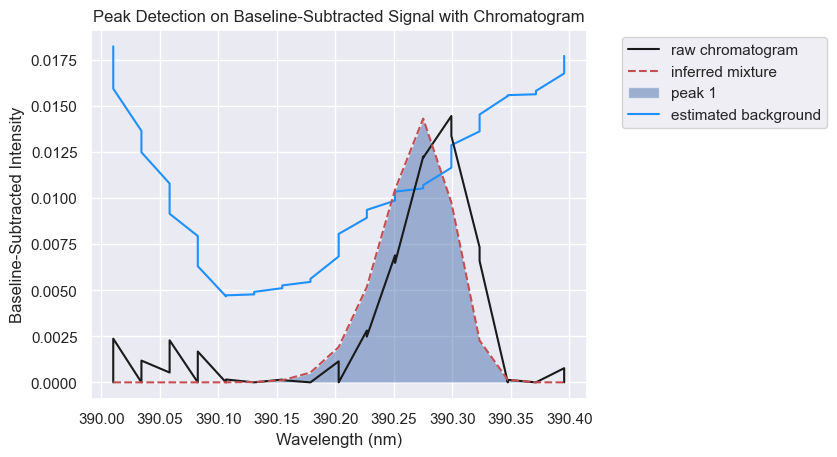

Number of peaks detected: 1
The plot has been saved as peak_detection_baseline_subtracted.pdf


In [6]:
import pandas as pd
from hplc.quant import Chromatogram
import matplotlib.pyplot as plt

# Assumed that `wavelengths` and `S_subtracted` are available
# `wavelengths` contains the wavelength values, and `S_subtracted` contains the baseline-subtracted signal

# Create a DataFrame from `wavelengths` and `S_subtracted`
df_signal = pd.DataFrame({
    'wavelength': wavelengths,  # Replace with 'time_min' if using time-based data
    'intensity_mV': S_subtracted
})
df_signal['intensity_mV'] = (df_signal['intensity_mV'] - df_signal['intensity_mV'].min()) / (df_signal['intensity_mV'].max() - df_signal['intensity_mV'].min())
# Initialize a Chromatogram object from this DataFrame
chrom = Chromatogram(df_signal, cols={'time': 'wavelength', 'signal': 'intensity_mV'}, time_window=[390,  390.4])

# Detect peaks with a prominence filter
peaks = chrom.fit_peaks(prominence=1)

# Plot and show peak detection results
fig, ax = chrom.show()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Baseline-Subtracted Intensity')
plt.title('Peak Detection on Baseline-Subtracted Signal with Chromatogram')
#plt.legend()
plt.grid(True)

# Save the plot as a PDF file
output_pdf = 'peak_detection_baseline_subtracted.pdf'
plt.savefig(output_pdf, format='pdf')

# Display the plot
plt.show()

# Print the number of peaks detected
print(f"Number of peaks detected: {len(peaks)}")
print(f"The plot has been saved as {output_pdf}")

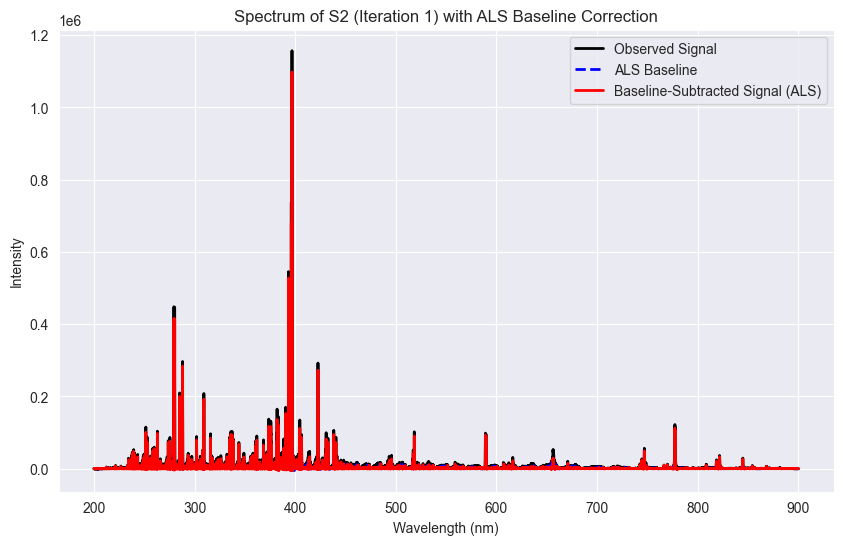

Baseline-subtracted signal (S_subtracted) using ALS:
[ -7.03358292  -4.3071414   -1.58062954 ... 219.02162029 179.85061201
 178.86371973]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Fungsi untuk melakukan koreksi baseline menggunakan ALS
def als_baseline(y, lam=1e5, p=0, niter=4):
    """
    Applies Asymmetric Least Squares (ALS) baseline correction.
    
    Parameters:
    y : array_like
        Input signal for baseline correction.
    lam : float
        Smoothness parameter for ALS (higher values make smoother baseline).
    p : float
        Asymmetry parameter (0 < p < 1). Typically close to zero for baseline correction.
    niter : int
        Number of iterations for ALS algorithm.

    Returns:
    baseline : array_like
        Estimated baseline after ALS correction.
    """
    L = len(y)
    D = diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    D = lam * D.dot(D.transpose())  # Matrix for smoothing
    w = np.ones(L)
    for i in range(niter):
        W = diags(w, 0)
        Z = W + D
        baseline = spsolve(Z, w * y)
        w = p * (y > baseline) + (1 - p) * (y < baseline)
    return baseline

# Fungsi untuk plot spektrum dengan baseline correction menggunakan ALS
def plot_spectrum_with_als_baseline(db_path, sample_name, iteration, lam=1e5, p=0, wavelength_min=None, wavelength_max=None):
    # Dapatkan data spektrum dari database
    wavelengths, intensities = get_spectrum_from_db(db_path, sample_name, iteration)
    
    # Filter data berdasarkan batas panjang gelombang jika disediakan
    if wavelength_min is not None and wavelength_max is not None:
        mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]

    # Terapkan ALS baseline correction
    baseline = als_baseline(intensities, lam=lam, p=p)
    corrected_signal = intensities - baseline  # Ini adalah S_subtracted menggunakan ALS
    
    # Plot hasil
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, 'k-', lw=2, label='Observed Signal')
    plt.plot(wavelengths, baseline, 'b--', lw=2, label='ALS Baseline')
    plt.plot(wavelengths, corrected_signal, 'r-', lw=2, label='Baseline-Subtracted Signal (ALS)')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f'Spectrum of {sample_name} (Iteration {iteration}) with ALS Baseline Correction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Kembalikan sinyal yang sudah dikurangi baseline
    return wavelengths, corrected_signal

wavelength_min=200
wavelength_max=900
# Contoh penggunaan untuk sampel S4 iterasi 3 dengan ALS baseline correction
wavelengths, S_subtracted_als = plot_spectrum_with_als_baseline(
    db_path, sample_name, iteration, lam=1e5, p=0, wavelength_min=wavelength_min, wavelength_max=wavelength_max
)

# Sekarang S_subtracted_als tersedia untuk digunakan lebih lanjut
print("Baseline-subtracted signal (S_subtracted) using ALS:")
print(S_subtracted_als)

In [3]:
import sqlite3

# Fungsi untuk menyimpan hasil baseline-subtracted ke dalam database
def save_baseline_subtracted_to_db(db_path, sample_name, iteration, wavelengths, S_subtracted):
    """
    Saves the baseline-subtracted signal to a SQLite database.

    Parameters:
    db_path : str
        Path to the SQLite database.
    sample_name : str
        Name of the sample to store in the database.
    iteration : int
        Iteration number of the sample.
    wavelengths : array_like
        Array of wavelengths corresponding to the baseline-subtracted signal.
    S_subtracted : array_like
        Baseline-subtracted signal to be saved.
    """
    # Buat koneksi ke database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Buat tabel baru jika belum ada
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS baseline_corrected_spectrum (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            sample_name TEXT,
            iteration INTEGER,
            wavelength REAL,
            intensity REAL
        )
    ''')
    
    # Masukkan data ke dalam tabel
    for wl, signal in zip(wavelengths, S_subtracted):
        cursor.execute('''
            INSERT INTO baseline_corrected_spectrum (sample_name, iteration, wavelength, baseline_subtracted_signal)
            VALUES (?, ?, ?, ?)
        ''', (sample_name, iteration, wl, signal))
    
    # Commit perubahan dan tutup koneksi
    conn.commit()
    conn.close()
    print(f"Baseline-subtracted signal for sample {sample_name} (Iteration {iteration}) saved to database.")

# Contoh penggunaan
db_path = 'processed_spectra.db'
sample_name = 'S2'
iteration = 1

# Simpan hasil S_subtracted_als ke dalam database
save_baseline_subtracted_to_db(db_path, sample_name, iteration, wavelengths, S_subtracted_als)

Baseline-subtracted signal for sample S2 (Iteration 1) saved to database.


In [5]:
import sqlite3
import pandas as pd

def save_baseline_subtracted_to_db_and_excel(db_path, excel_path, sample_name, iteration, wavelengths, S_subtracted):
    """
    Saves the baseline-subtracted signal to a SQLite database and an Excel file.

    Parameters:
    db_path : str
        Path to the SQLite database.
    excel_path : str
        Path to the Excel file.
    sample_name : str
        Name of the sample to store in the database and Excel.
    iteration : int
        Iteration number of the sample.
    wavelengths : array_like
        Array of wavelengths corresponding to the baseline-subtracted signal.
    S_subtracted : array_like
        Baseline-subtracted signal to be saved.
    """
    # Buat koneksi ke database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Buat tabel baru jika belum ada
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS baseline_corrected_spectrum (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            sample_name TEXT,
            iteration INTEGER,
            wavelength REAL,
            baseline_subtracted_signal REAL
        )
    ''')
    
    # Masukkan data ke dalam tabel
    data_to_insert = []
    for wl, signal in zip(wavelengths, S_subtracted):
        data_to_insert.append((sample_name, iteration, wl, signal))
        cursor.execute('''
            INSERT INTO baseline_corrected_spectrum (sample_name, iteration, wavelength, baseline_subtracted_signal)
            VALUES (?, ?, ?, ?)
        ''', (sample_name, iteration, wl, signal))
    
    # Commit perubahan ke database
    conn.commit()
    conn.close()
    print(f"Baseline-subtracted signal for sample {sample_name} (Iteration {iteration}) saved to database.")

    # Simpan data ke file Excel
    df = pd.DataFrame(data_to_insert, columns=['Sample Name', 'Iteration', 'Wavelength', 'Baseline Subtracted Signal'])
    try:
        # Jika file Excel sudah ada, tambahkan sheet baru atau gabungkan data
        with pd.ExcelWriter(excel_path, mode='a', engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name=f'{sample_name}_Iter{iteration}', index=False)
    except FileNotFoundError:
        # Jika file tidak ada, buat baru
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name=f'{sample_name}_Iter{iteration}', index=False)
    
    print(f"Baseline-subtracted signal for sample {sample_name} (Iteration {iteration}) saved to Excel at {excel_path}.")

# Contoh penggunaan
db_path = 'processed_spectra.db'
excel_path = 'baseline_corrected_spectrum.xlsx'
sample_name = 'S2'
iteration = 2

# Simpan hasil S_subtracted_als ke dalam database dan Excel
save_baseline_subtracted_to_db_and_excel(db_path, excel_path, sample_name, iteration, wavelengths, S_subtracted_als)

Baseline-subtracted signal for sample S2 (Iteration 2) saved to database.
Baseline-subtracted signal for sample S2 (Iteration 2) saved to Excel at baseline_corrected_spectrum.xlsx.


In [19]:
import numpy as np
import pandas as pd
import sqlite3
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from lmfit.models import VoigtModel
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Implementasi dekonvolusi Richardson-Lucy
def richardson_lucy(image, psf, iterations=50):
    """
    Implementasi iteratif dekonvolusi Richardson-Lucy.

    Parameters:
    - image: array-like
        Data yang akan didekonvolusi.
    - psf: array-like
        Fungsi penyebaran titik (Point Spread Function).
    - iterations: int
        Jumlah iterasi untuk dekonvolusi.

    Returns:
    - result: array-like
        Data hasil dekonvolusi.
    """
    image = np.asarray(image, dtype=np.float64)
    psf = np.asarray(psf, dtype=np.float64)

    psf /= psf.sum()  # Normalisasi PSF
    result = np.full_like(image, 0.5)  # Inisialisasi hasil dekonvolusi

    for _ in range(iterations):
        relative_blur = image / (np.convolve(result, psf, mode='same') + 1e-8)
        result *= np.convolve(relative_blur, psf[::-1], mode='same')

    return result

# Fungsi smoothing menggunakan Savitzky-Golay
def smooth_data(intensities, window_length=5, polyorder=2):
    if len(intensities) < window_length:
        return intensities
    return savgol_filter(intensities, window_length=window_length, polyorder=polyorder)

# Fungsi baseline correction menggunakan ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=10):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Fungsi untuk mendapatkan intensitas terintegrasi dengan fitting Voigt
def get_integrated_intensity_with_voigt_fitting(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []
    peak_details = []

    for idx, wl_exp in enumerate(exp_wavelengths):
        query = """
            SELECT wavelength, baseline_subtracted_signal
            FROM baseline_corrected_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.5
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            wavelengths = np.array(wavelengths)
            intensities = np.array(intensities)

            # Periksa delta_wavelength
            if len(wavelengths) > 1:
                delta_wavelength = wavelengths[1] - wavelengths[0]
                if delta_wavelength <= 0:
                    delta_wavelength = 0.01  # Nilai default kecil
            else:
                print(f"Panjang data wavelength tidak cukup untuk perhitungan pada {wl_exp} nm.")
                integrated_intensities.append(None)
                continue

            kernel_sigma_nm = 0.1
            kernel_sigma_pix = kernel_sigma_nm / delta_wavelength
            kernel_size = int(np.ceil(8 * kernel_sigma_pix))
            if kernel_size % 2 == 0:
                kernel_size += 1

            # Pastikan kernel_size tidak melebihi panjang data
            kernel_size = min(kernel_size, len(wavelengths))

            # Membuat PSF
            x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
            psf = norm.pdf(x, scale=kernel_sigma_pix)
            psf /= psf.sum()

            # Dekonvolusi menggunakan Richardson-Lucy
            intensities_corrected = intensities - baseline_als(intensities)
            intensities_corrected -= np.min(intensities_corrected)
            intensities_corrected /= np.max(intensities_corrected)
            intensities_deconvolved = richardson_lucy(intensities_corrected, psf, iterations=30)

            # Deteksi puncak
            peaks, _ = find_peaks(intensities_deconvolved, prominence=0.05)
            if len(peaks) > 0:
                idx_closest_peak = np.argmin(np.abs(wavelengths[peaks] - wl_exp))
                main_peak_idx = peaks[idx_closest_peak]

                left_idx = max(main_peak_idx - 10, 0)
                right_idx = min(main_peak_idx + 10, len(wavelengths) - 1)
                x_data = wavelengths[left_idx:right_idx+1]
                y_data = intensities_deconvolved[left_idx:right_idx+1]

                voigt_model = VoigtModel()
                params = voigt_model.make_params(amplitude=np.max(y_data), center=wl_exp, sigma=0.05, gamma=0.05)
                params['amplitude'].set(min=0)
                params['center'].set(min=wl_exp - 0.1, max=wl_exp + 0.1)
                params['sigma'].set(min=0)
                params['gamma'].set(min=0)

                result = voigt_model.fit(y_data, params, x=x_data)

                if result.success:
                    area = result.params['amplitude'].value * np.sqrt(2 * np.pi) * result.params['sigma'].value
                    integrated_intensities.append(area)
                else:
                    integrated_intensities.append(None)
            else:
                integrated_intensities.append(None)
        else:
            integrated_intensities.append(None)

    conn.close()
    return integrated_intensities

# Fungsi utama
db_processed = 'processed_spectra.db'
sample_name = 'S1'
exp_wavelengths = [292.4, 422.7]  # Contoh panjang gelombang

integrated_intensities = get_integrated_intensity_with_voigt_fitting(db_processed, sample_name, exp_wavelengths)

print("Intensitas terintegrasi untuk setiap panjang gelombang:")
for wl, intensity in zip(exp_wavelengths, integrated_intensities):
    print(f"Panjang gelombang {wl} nm: {intensity}")

Intensitas terintegrasi untuk setiap panjang gelombang:
Panjang gelombang 292.4 nm: 0.004039150957670877
Panjang gelombang 422.7 nm: 178784.36152566833


2024-11-24 23:31:22.261 Python[10324:671729] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-24 23:31:22.261 Python[10324:671729] +[IMKInputSession subclass]: chose IMKInputSession_Modern


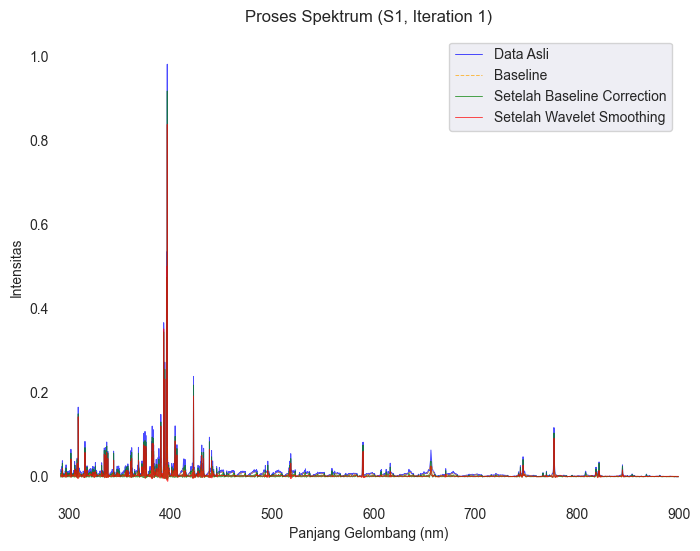

In [1]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pywt  # Modul untuk Wavelet Transform


# Fungsi untuk baseline correction menggunakan ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z
def wavelet_smoothing(data, wavelet='db1', level=3, threshold=0.2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    coeffs[1:] = [pywt.threshold(c, threshold * max(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()

    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None


# Fungsi untuk menyimpan hasil ke database
def export_to_database(wavelengths, smoothed_intensities):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    # Buat tabel jika belum ada
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS processed_spectrum (
            sample_name TEXT,
            iteration INTEGER,
            wavelength REAL,
            intensity REAL
        )
    """)

    # Insert data
    sample = sample_var.get()
    iteration = int(iteration_var.get())
    for wl, intensity in zip(wavelengths, smoothed_intensities):
        cursor.execute("""
            INSERT INTO processed_spectrum (sample_name, iteration, wavelength, intensity)
            VALUES (?, ?, ?, ?)
        """, (sample, iteration, wl, intensity))

    conn.commit()
    conn.close()
    status_label.config(text=f"Hasil disimpan ke database untuk {sample}, Iteration {iteration}.")
# Fungsi untuk memperbarui plot
def update_plot():
    global fig, ax  # Pastikan fig dan ax dapat diakses di fungsi ini

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelet_type = wavelet_var.get()
    level = int(level_var.get())
    threshold = float(threshold_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    # Potong data berdasarkan rentang panjang gelombang
    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    # Normalisasi data
    intensities = intensities / np.max(intensities)

    # Lakukan baseline correction
    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    # Lakukan wavelet smoothing
    smoothed_intensities = wavelet_smoothing(corrected_intensities, wavelet=wavelet_type, level=level, threshold=threshold)

    # Tambahkan smoothing tambahan menggunakan Savitzky-Golay
    from scipy.signal import savgol_filter
    smoothed_intensities = savgol_filter(smoothed_intensities, window_length=7, polyorder=3)

    # Subsampling untuk plot
    step = 5  # Hanya setiap 5 titik yang diplot untuk mengurangi kepadatan
    wavelengths_sub = wavelengths[::step]
    intensities_sub = intensities[::step]
    baseline_sub = baseline[::step]
    corrected_sub = corrected_intensities[::step]
    smoothed_sub = smoothed_intensities[::step]
    ax.clear()
    fig.patch.set_alpha(0)  
    ax.set_facecolor((1, 1, 1, 0))  
    ax.grid(False) 
    ax.set_xlim(wavelength_min, wavelength_max)  
    ax.set_ylim(-0.05, 1.05)  
    ax.plot(wavelengths_sub, intensities_sub, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths_sub, baseline_sub, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths_sub, corrected_sub, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths_sub, smoothed_sub, label='Setelah Wavelet Smoothing', color='red', alpha=0.7, linewidth=0.7)
    ax.set_title(f"Proses Spektrum ({sample}, Iteration {iteration})", pad=10)
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend()
    canvas.draw()
    status_label.config(text="Plot diperbarui.")


def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var, wavelet_var, level_var, threshold_var, status_label, sample_var, fig  # Pastikan fig global
    db_processed = 'tanah_vulkanik.db'

#TKINTER
    root = tk.Tk()
    root.title("Interaktif Baseline Correction dan Wavelet Smoothing")
    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)
    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Wavelet Type:").pack(anchor=tk.W)
    wavelet_var = tk.StringVar(value="db4")
    wavelet_dropdown = ttk.Combobox(control_frame, textvariable=wavelet_var, state="readonly")
    wavelet_dropdown['values'] = pywt.wavelist(kind="discrete")
    wavelet_dropdown.pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Wavelet Level:").pack(anchor=tk.W)
    level_var = tk.StringVar(value="2")
    ttk.Entry(control_frame, textvariable=level_var).pack(anchor=tk.W, fill=tk.X)
    ttk.Label(control_frame, text="Wavelet Threshold:").pack(anchor=tk.W)
    threshold_var = tk.StringVar(value="0.02")
    ttk.Entry(control_frame, textvariable=threshold_var).pack(anchor=tk.W, fill=tk.X)
    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)
    status_label = ttk.Label(control_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)
    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    global fig
    fig, ax = plt.subplots(figsize=(8, 6)) 
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)
    root.mainloop()
if __name__ == "__main__":
    main_app()




In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
import pywt
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Wavelet Smoothing
def wavelet_smoothing(data, wavelet='db1', level=3, threshold=0.2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    coeffs[1:] = [pywt.threshold(c, threshold * max(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# Load Data
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 0.1, peak_center + 0.1)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est, fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.01
        voigt.fwhm_L.max = 0.2
        voigt.fwhm_G.min = 0.01
        voigt.fwhm_G.max = 0.2

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Calculate area under each peak
    peak_areas = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        peak_mask = (wavelengths >= x_0 - 0.5) & (wavelengths <= x_0 + 0.5)
        peak_wavelengths = wavelengths[peak_mask]
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)
        peak_areas[f"Peak {i+1}"] = area

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_areas

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models, peak_indices):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = wavelengths[(wavelengths >= model.x_0.value - 0.5) & (wavelengths <= model.x_0.value + 0.5)]
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Perform Deconvolution
def perform_deconvolution():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        fitted_model_total, individual_models, peak_areas = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models, peak_indices)
        area_text = ", ".join([f"{k}: {v:.4f}" for k, v in peak_areas.items()])
        status_label.config(text=f"Dekonvolusi berhasil. Area puncak: {area_text}")
    except ValueError as e:
        status_label.config(text=str(e))

# Update Plot
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelet_type = wavelet_var.get()
    level = int(level_var.get())
    threshold = float(threshold_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    intensities = intensities / np.max(intensities)

    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    smoothed_intensities = wavelet_smoothing(corrected_intensities, wavelet=wavelet_type, level=level, threshold=threshold)

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=10, prominence=0.04)

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, smoothed_intensities, label='Setelah Wavelet Smoothing', color='red', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")
    ax.set_title(f"Proses Spektrum ({sample}, Iteration {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text="Plot diperbarui.")

# Main App
def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var, wavelet_var, level_var, threshold_var, status_label, sample_var, fig, max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction, Wavelet Smoothing, dan Voigt Fitting")
    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Type:").pack(anchor=tk.W)
    wavelet_var = tk.StringVar(value="db4")
    wavelet_dropdown = ttk.Combobox(control_frame, textvariable=wavelet_var, state="readonly")
    wavelet_dropdown['values'] = pywt.wavelist(kind="discrete")
    wavelet_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Level:").pack(anchor=tk.W)
    level_var = tk.StringVar(value="2")
    ttk.Entry(control_frame, textvariable=level_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Threshold:").pack(anchor=tk.W)
    threshold_var = tk.StringVar(value="0.02")
    ttk.Entry(control_frame, textvariable=threshold_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Jumlah Puncak Maks:").pack(anchor=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(control_frame, textvariable=max_peaks_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_lorentz_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_gaussian_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Peak Height Threshold:").pack(anchor=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=height_threshold_var).pack(anchor=tk.W, fill=tk.X)

    deconvolution_button = ttk.Button(control_frame, text="Perform Deconvolution", command=perform_deconvolution)
    deconvolution_button.pack(anchor=tk.W, pady=5)

    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    status_label = ttk.Label(control_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)

    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()


if __name__ == "__main__":
    main_app()

2024-11-25 13:31:12.385 Python[21353:1279516] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-25 13:31:12.385 Python[21353:1279516] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [1]:
#batas

TypeError: unsupported operand type(s) for +: 'int' and 'VoigtModel'

In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pywt
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Wavelet Smoothing
def wavelet_smoothing(data, wavelet='db1', level=3, threshold=0.2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    coeffs[1:] = [pywt.threshold(c, threshold * np.max(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, exp_peak_wls, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_center in enumerate(exp_peak_wls):
        amplitude_est = np.interp(peak_center, wavelengths, intensities)
        peak_range = (peak_center - 1.0, peak_center + 1.0)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.01
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.01
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 1.0, x_0 + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')

# Perform Deconvolution and Save Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask, excel_df

    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    sample = sample_var.get()
    iteration = int(iteration_var.get())

    # Get Exp Peak WL values for the sample
    exp_peak_wls = excel_df['Exp Peak WL'].values
    exp_peak_wls = exp_peak_wls.astype(float)

    try:
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, exp_peak_wls, fwhm_lorentz, fwhm_gaussian
        )
        fig.clear()
        ax = fig.add_subplot(1, 1, 1)
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)
        ax.set_title(f"Deconvolution Result ({sample}, Iterasi {iteration})")
        ax.set_xlabel("Panjang Gelombang (nm)")
        ax.set_ylabel("Intensitas")
        ax.grid(True)
        fig.tight_layout()
        canvas.draw()

        # Prepare data for Excel
        data_to_save = []
        for i, (key, data) in enumerate(peak_data.items()):
            data_to_save.append({
                'Sample': sample,
                'Iteration': iteration,
                'Exp Peak WL': exp_peak_wls[i],
                'Fitted x_0': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'deconvolution_results.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data dekonvolusi telah ditambahkan ke 'deconvolution_results.xlsx'.")

        # Save plot as image
        image_filename = f"Deconvolution_{sample}_Iter{iteration}.png"
        fig.savefig(image_filename)
        status_label.config(text=status_label.cget("text") + f" Plot disimpan sebagai '{image_filename}'.")

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelet_type = wavelet_var.get()
    level = int(level_var.get())
    threshold = float(threshold_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    # Use original intensities without normalization
    # intensities = intensities / np.max(intensities)  # Commented out normalization

    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    smoothed_intensities = wavelet_smoothing(corrected_intensities, wavelet=wavelet_type, level=level, threshold=threshold)

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, smoothed_intensities, label='Setelah Wavelet Smoothing', color='red', alpha=0.7, linewidth=0.7)
    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text="Plot diperbarui.")

# Load Excel Data
def load_excel_data():
    global excel_df
    try:
        # Update with your Excel file path
        excel_file_path = 'completed_data1.xlsx'  # Replace with your actual file name
        excel_df = pd.read_excel(excel_file_path)
        required_columns = ['Exp Peak WL']
        for col in required_columns:
            if col not in excel_df.columns:
                status_label.config(text=f"Kolom '{col}' tidak ditemukan di file Excel.")
                excel_df = None
                return
        status_label.config(text="File Excel berhasil dimuat.")
    except Exception as e:
        status_label.config(text=f"Gagal memuat file Excel: {e}")
        excel_df = None

# Main App
def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var
    global wavelet_var, level_var, threshold_var, status_label, sample_var, fig
    global fwhm_lorentz_var, fwhm_gaussian_var
    global excel_df

    db_processed = 'tanah_vulkanik.db'
    excel_df = None

    root = tk.Tk()
    root.title("Interaktif Baseline Correction, Wavelet Smoothing, dan Voigt Fitting")
    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    status_label = ttk.Label(control_frame, text="Memuat aplikasi...")
    status_label.pack(anchor=tk.W, pady=5)

    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="280")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="450")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Type:").pack(anchor=tk.W)
    wavelet_var = tk.StringVar(value="db4")
    wavelet_dropdown = ttk.Combobox(control_frame, textvariable=wavelet_var, state="readonly")
    wavelet_dropdown['values'] = pywt.wavelist(kind="discrete")
    wavelet_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Level:").pack(anchor=tk.W)
    level_var = tk.StringVar(value="2")
    ttk.Entry(control_frame, textvariable=level_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Threshold:").pack(anchor=tk.W)
    threshold_var = tk.StringVar(value="0.02")
    ttk.Entry(control_frame, textvariable=threshold_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_lorentz_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_gaussian_var).pack(anchor=tk.W, fill=tk.X)

    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    deconvolution_button = ttk.Button(control_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.pack(anchor=tk.W, pady=5)

    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    # Load Excel Data when the application starts
    load_excel_data()

    # Update status_label
    if excel_df is not None:
        status_label.config(text="Masukkan parameter dan tekan 'Update Plot'.")
    else:
        status_label.config(text="Gagal memuat data Excel.")

    root.mainloop()

if __name__ == "__main__":
    main_app()

2024-11-26 00:23:28.997 Python[31134:1901038] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-26 00:23:28.997 Python[31134:1901038] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
import pywt
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os  # Import os untuk memeriksa keberadaan file

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Wavelet Smoothing
def wavelet_smoothing(data, wavelet='db1', level=3, threshold=0.2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    coeffs[1:] = [pywt.threshold(c, threshold * np.max(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 1.0, peak_center + 1.0)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.01
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.01
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 1.0, x_0 + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Perform Deconvolution and Save Selected Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)

        # Get selected peaks from the Listbox
        selected_indices = peak_listbox.curselection()
        if not selected_indices:
            status_label.config(text="Tidak ada puncak yang dipilih untuk disimpan.")
            return

        # Prepare data for Excel
        data_to_save = []
        for idx in selected_indices:
            peak_label = f"Peak {idx+1}"
            data = peak_data[peak_label]
            data_to_save.append({
                'Sample': sample_var.get(),
                'Iteration': iteration_var.get(),
                'Peak Number': idx + 1,
                'x_0 (Peak Center)': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'selected_fitting_peaks.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data puncak hasil fitting telah ditambahkan ke 'selected_fitting_peaks.xlsx'.")

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot and Peaks List
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelet_type = wavelet_var.get()
    level = int(level_var.get())
    threshold = float(threshold_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    # Use original intensities without normalization
    # intensities = intensities / np.max(intensities)  # Commented out normalization

    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    smoothed_intensities = wavelet_smoothing(corrected_intensities, wavelet=wavelet_type, level=level, threshold=threshold)

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=1, prominence=0.04)

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, smoothed_intensities, label='Setelah Wavelet Smoothing', color='red', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")
    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text="Plot diperbarui.")

    # Update peak listbox
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

# Main App
def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var
    global wavelet_var, level_var, threshold_var, status_label, sample_var, fig
    global max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    global peak_listbox

    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction, Wavelet Smoothing, dan Voigt Fitting")
    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    status_label = ttk.Label(control_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)

    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Type:").pack(anchor=tk.W)
    wavelet_var = tk.StringVar(value="db4")
    wavelet_dropdown = ttk.Combobox(control_frame, textvariable=wavelet_var, state="readonly")
    wavelet_dropdown['values'] = pywt.wavelist(kind="discrete")
    wavelet_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Level:").pack(anchor=tk.W)
    level_var = tk.StringVar(value="2")
    ttk.Entry(control_frame, textvariable=level_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Threshold:").pack(anchor=tk.W)
    threshold_var = tk.StringVar(value="0.02")
    ttk.Entry(control_frame, textvariable=threshold_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Jumlah Puncak Maks:").pack(anchor=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(control_frame, textvariable=max_peaks_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_lorentz_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_gaussian_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Peak Height Threshold:").pack(anchor=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=height_threshold_var).pack(anchor=tk.W, fill=tk.X)

    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    # Listbox for peak selection
    ttk.Label(control_frame, text="Pilih Puncak untuk Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    peak_listbox = tk.Listbox(control_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.pack(anchor=tk.W, fill=tk.X)

    deconvolution_button = ttk.Button(control_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.pack(anchor=tk.W, pady=5)

    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()

if __name__ == "__main__":
    main_app()

2024-11-26 22:16:47.482 Python[44974:2639410] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-26 22:16:47.482 Python[44974:2639410] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
import pywt
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os  # Import os untuk memeriksa keberadaan file

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Wavelet Smoothing
def wavelet_smoothing(data, wavelet='db1', level=3, threshold=0.2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    coeffs[1:] = [pywt.threshold(c, threshold * np.max(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None
def adjust_fwhm_lorentz(delta):
    """Adjust the FWHM Lorentzian by delta and update the plot."""
    current_value = float(fwhm_lorentz_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.01
    fwhm_lorentz_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def adjust_fwhm_gaussian(delta):
    """Adjust the FWHM Gaussian by delta and update the plot."""
    current_value = float(fwhm_gaussian_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.01
    fwhm_gaussian_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def add_fwhm_adjust_buttons(frame):
    """Add buttons to adjust FWHM Lorentzian and Gaussian."""
    # Lorentzian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_frame = ttk.Frame(frame)
    fwhm_lorentz_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    # Gaussian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_frame = ttk.Frame(frame)
    fwhm_gaussian_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)
# Multi-Peak Deconvolution using Astropy

def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 0.5, peak_center + 0.5)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.01
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.01
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 0.5, x_0 + 0.5, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Perform Deconvolution and Save Selected Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)

        # Get selected peaks from the Listbox
        selected_indices = peak_listbox.curselection()
        if not selected_indices:
            status_label.config(text="Tidak ada puncak yang dipilih untuk disimpan.")
            return

        # Prepare data for Excel
        data_to_save = []
        for idx in selected_indices:
            peak_label = f"Peak {idx+1}"
            data = peak_data[peak_label]
            data_to_save.append({
                'Sample': sample_var.get(),
                'Iteration': iteration_var.get(),
                'Peak Number': idx + 1,
                'x_0 (Peak Center)': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'selected_fitting_peaks.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data puncak hasil fitting telah ditambahkan ke 'selected_fitting_peaks.xlsx'.")

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot and Peaks List
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelet_type = wavelet_var.get()
    level = int(level_var.get())
    threshold = float(threshold_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    if len(wavelengths) == 0:
        status_label.config(text="Tidak ada data dalam rentang panjang gelombang ini.")
        return

    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    smoothed_intensities = wavelet_smoothing(corrected_intensities, wavelet=wavelet_type, level=level, threshold=threshold)

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=5, prominence=0.01)

    if len(peaks) == 0:
        status_label.config(text="Tidak ada puncak yang terdeteksi. Periksa parameter deteksi.")
        return

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, smoothed_intensities, label='Setelah Wavelet Smoothing', color='red', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")
    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text=f"{len(peaks)} puncak terdeteksi.")

    # Update peak listbox
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

# Tambahkan fungsi display_saved_peaks_in_table() di atas
def display_saved_peaks_in_table():
    """Display the selected peaks (x_0 and Area under Peak) from Excel in a GUI table."""
    excel_file = 'selected_fitting_peaks.xlsx'
    
    if not os.path.exists(excel_file):
        status_label.config(text="File 'selected_fitting_peaks.xlsx' tidak ditemukan.")
        return

    try:
        # Baca data dari Excel
        df = pd.read_excel(excel_file)
        
        # Pastikan kolom x_0 dan Area under Peak tersedia
        if 'x_0 (Peak Center)' not in df.columns or 'Area under Peak' not in df.columns:
            status_label.config(text="Kolom 'x_0' atau 'Area under Peak' tidak ditemukan di file.")
            return

        # Kosongkan tabel sebelumnya
        for row in result_table.get_children():
            result_table.delete(row)

        # Isi tabel dengan data baru
        for _, row in df.iterrows():
            result_table.insert("", "end", values=(row['x_0 (Peak Center)'], row['Area under Peak']))

        status_label.config(text="Data puncak berhasil ditampilkan di tabel.")
    
    except Exception as e:
        status_label.config(text=f"Error membaca file Excel: {e}")

# Modifikasi main_app
def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var
    global wavelet_var, level_var, threshold_var, status_label, sample_var, fig
    global max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    global peak_listbox, result_table

    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction, Wavelet Smoothing, dan Voigt Fitting")
    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    status_label = ttk.Label(control_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)

    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Type:").pack(anchor=tk.W)
    wavelet_var = tk.StringVar(value="db4")
    wavelet_dropdown = ttk.Combobox(control_frame, textvariable=wavelet_var, state="readonly")
    wavelet_dropdown['values'] = pywt.wavelist(kind="discrete")
    wavelet_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Level:").pack(anchor=tk.W)
    level_var = tk.StringVar(value="2")
    ttk.Entry(control_frame, textvariable=level_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Threshold:").pack(anchor=tk.W)
    threshold_var = tk.StringVar(value="0.02")
    ttk.Entry(control_frame, textvariable=threshold_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Jumlah Puncak Maks:").pack(anchor=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(control_frame, textvariable=max_peaks_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    fwhm_lorentz_frame = ttk.Frame(control_frame)
    fwhm_lorentz_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    fwhm_gaussian_frame = ttk.Frame(control_frame)
    fwhm_gaussian_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

    ttk.Label(control_frame, text="Peak Height Threshold:").pack(anchor=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=height_threshold_var).pack(anchor=tk.W, fill=tk.X)

    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    # Listbox for peak selection
    ttk.Label(control_frame, text="Pilih Puncak untuk Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    peak_listbox = tk.Listbox(control_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.pack(anchor=tk.W, fill=tk.X)

    deconvolution_button = ttk.Button(control_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.pack(anchor=tk.W, pady=5)

    # Tabel untuk menampilkan hasil
    ttk.Label(control_frame, text="Hasil Puncak yang Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    result_table = ttk.Treeview(control_frame, columns=("Peak Center", "Area"), show="headings", height=10)
    result_table.heading("Peak Center", text="Peak Center (x_0)")
    result_table.heading("Area", text="Area under Peak")
    result_table.column("Peak Center", anchor=tk.CENTER, width=120)
    result_table.column("Area", anchor=tk.CENTER, width=120)
    result_table.pack(anchor=tk.W, fill=tk.X)

    # Tombol untuk menampilkan hasil
    show_results_button = ttk.Button(control_frame, text="Tampilkan Hasil Puncak",
                                      command=display_saved_peaks_in_table)
    show_results_button.pack(anchor=tk.W, pady=5)

    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()

if __name__ == "__main__":
    main_app()

In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
import pywt
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os

# DataFetcher class to fetch NIST data
class DataFetcher:
    def __init__(self, db_nist):
        self.db_nist = db_nist

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

# SpectrumSimulator class to simulate atomic spectrum
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        if not energy_levels:
            return None, None

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1  # Adjust sigma as needed
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Wavelet Smoothing
def wavelet_smoothing(data, wavelet='db1', level=3, threshold=0.2):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    coeffs[1:] = [pywt.threshold(c, threshold * np.max(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

def adjust_fwhm_lorentz(delta):
    """Adjust the FWHM Lorentzian by delta and update the plot."""
    current_value = float(fwhm_lorentz_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_lorentz_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def adjust_fwhm_gaussian(delta):
    """Adjust the FWHM Gaussian by delta and update the plot."""
    current_value = float(fwhm_gaussian_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_gaussian_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def add_fwhm_adjust_buttons(frame):
    """Add buttons to adjust FWHM Lorentzian and Gaussian."""
    # Lorentzian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_frame = ttk.Frame(frame)
    fwhm_lorentz_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    # Gaussian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_frame = ttk.Frame(frame)
    fwhm_gaussian_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 0.5, peak_center + 0.5)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.005
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.005
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 0.5, x_0 + 0.5, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Perform Deconvolution and Save Selected Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)

        # Get selected peaks from the Listbox
        selected_indices = peak_listbox.curselection()
        if not selected_indices:
            status_label.config(text="Tidak ada puncak yang dipilih untuk disimpan.")
            return

        # Prepare data for Excel
        data_to_save = []
        for idx in selected_indices:
            peak_label = f"Peak {idx+1}"
            data = peak_data[peak_label]
            data_to_save.append({
                'Sample': sample_var.get(),
                'Iteration': iteration_var.get(),
                'Peak Number': idx + 1,
                'x_0 (Peak Center)': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'selected_fitting_peaks.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data puncak hasil fitting telah ditambahkan ke 'selected_fitting_peaks.xlsx'.")

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot and Peaks List
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelet_type = wavelet_var.get()
    level = int(level_var.get())
    threshold = float(threshold_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    if len(wavelengths) == 0:
        status_label.config(text="Tidak ada data dalam rentang panjang gelombang ini.")
        return

    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    smoothed_intensities = wavelet_smoothing(corrected_intensities, wavelet=wavelet_type, level=level, threshold=threshold)

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=5, prominence=0.01)

    if len(peaks) == 0:
        status_label.config(text="Tidak ada puncak yang terdeteksi. Periksa parameter deteksi.")
        return

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, smoothed_intensities, label='Setelah Wavelet Smoothing', color='red', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")

    # Fetch NIST data and simulate atomic spectrum
    element = element_var.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_var.get())

    data_fetcher = DataFetcher(db_nist='data1.db')
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    if nist_data:
        simulator = SpectrumSimulator(nist_data, temperature)
        sim_wavelengths, sim_intensities = simulator.simulate()

        if sim_wavelengths is not None:
            # Limit simulated wavelengths to the range of sample data
            sim_mask = (sim_wavelengths >= wavelength_min) & (sim_wavelengths <= wavelength_max)
            sim_wavelengths = sim_wavelengths[sim_mask]
            sim_intensities = sim_intensities[sim_mask]

            # Normalize simulated intensities with the maximum of sample data
            max_sample_intensity = np.max(corrected_intensities)
            sim_intensities_normalized = sim_intensities / np.max(sim_intensities) * max_sample_intensity

            ax.plot(sim_wavelengths, sim_intensities_normalized, label=f'Simulated Spectrum ({element} {sp_num})', color='cyan', alpha=0.7, linewidth=0.7)
        else:
            status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")
    else:
        status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")

    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text=f"{len(peaks)} puncak terdeteksi.")

    # Update peak listbox
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

# Function to display saved peaks in the table
def display_saved_peaks_in_table():
    """Display the selected peaks (x_0 and Area under Peak) from Excel in a GUI table."""
    excel_file = 'selected_fitting_peaks.xlsx'

    if not os.path.exists(excel_file):
        status_label.config(text="File 'selected_fitting_peaks.xlsx' tidak ditemukan.")
        return

    try:
        # Baca data dari Excel
        df = pd.read_excel(excel_file)

        # Pastikan kolom x_0 dan Area under Peak tersedia
        if 'x_0 (Peak Center)' not in df.columns or 'Area under Peak' not in df.columns:
            status_label.config(text="Kolom 'x_0' atau 'Area under Peak' tidak ditemukan di file.")
            return

        # Kosongkan tabel sebelumnya
        for row in result_table.get_children():
            result_table.delete(row)

        # Isi tabel dengan data baru
        for _, row in df.iterrows():
            result_table.insert("", "end", values=(row['x_0 (Peak Center)'], row['Area under Peak']))

        status_label.config(text="Data puncak berhasil ditampilkan di tabel.")

    except Exception as e:
        status_label.config(text=f"Error membaca file Excel: {e}")

def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var
    global wavelet_var, level_var, threshold_var, status_label, sample_var, fig
    global max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    global peak_listbox, result_table
    global element_var, ion_stage_var, temperature_var

    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction, Wavelet Smoothing, dan Voigt Fitting")

    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    status_label = ttk.Label(control_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)

    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Type:").pack(anchor=tk.W)
    wavelet_var = tk.StringVar(value="db4")
    wavelet_dropdown = ttk.Combobox(control_frame, textvariable=wavelet_var, state="readonly")
    wavelet_dropdown['values'] = pywt.wavelist(kind="discrete")
    wavelet_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Level:").pack(anchor=tk.W)
    level_var = tk.StringVar(value="2")
    ttk.Entry(control_frame, textvariable=level_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelet Threshold:").pack(anchor=tk.W)
    threshold_var = tk.StringVar(value="0.02")
    ttk.Entry(control_frame, textvariable=threshold_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Jumlah Puncak Maks:").pack(anchor=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(control_frame, textvariable=max_peaks_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    fwhm_lorentz_frame = ttk.Frame(control_frame)
    fwhm_lorentz_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    fwhm_gaussian_frame = ttk.Frame(control_frame)
    fwhm_gaussian_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

    ttk.Label(control_frame, text="Peak Height Threshold:").pack(anchor=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=height_threshold_var).pack(anchor=tk.W, fill=tk.X)

    # Add Element and Ion Stage selection
    ttk.Label(control_frame, text="Element:").pack(anchor=tk.W)
    element_var = tk.StringVar(value="Fe")
    ttk.Entry(control_frame, textvariable=element_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Ion Stage:").pack(anchor=tk.W)
    ion_stage_var = tk.StringVar(value="1")
    ion_stage_dropdown = ttk.Combobox(control_frame, textvariable=ion_stage_var, state="readonly")
    ion_stage_dropdown['values'] = [str(i) for i in range(1, 6)]
    ion_stage_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Temperature (K):").pack(anchor=tk.W)
    temperature_var = tk.StringVar(value="11600")
    ttk.Entry(control_frame, textvariable=temperature_var).pack(anchor=tk.W, fill=tk.X)

    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    # Listbox for peak selection
    ttk.Label(control_frame, text="Pilih Puncak untuk Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    peak_listbox = tk.Listbox(control_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.pack(anchor=tk.W, fill=tk.X)

    deconvolution_button = ttk.Button(control_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.pack(anchor=tk.W, pady=5)

    # Tabel untuk menampilkan hasil
    ttk.Label(control_frame, text="Hasil Puncak yang Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    result_table = ttk.Treeview(control_frame, columns=("Peak Center", "Area"), show="headings", height=10)
    result_table.heading("Peak Center", text="Peak Center (x_0)")
    result_table.heading("Area", text="Area under Peak")
    result_table.column("Peak Center", anchor=tk.CENTER, width=120)
    result_table.column("Area", anchor=tk.CENTER, width=120)
    result_table.pack(anchor=tk.W, fill=tk.X)

    # Tombol untuk menampilkan hasil
    show_results_button = ttk.Button(control_frame, text="Tampilkan Hasil Puncak",
                                      command=display_saved_peaks_in_table)
    show_results_button.pack(anchor=tk.W, pady=5)

    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()

if __name__ == "__main__":
    main_app()

2024-11-29 09:18:46.374 Python[7322:378959] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-29 09:18:46.374 Python[7322:378959] +[IMKInputSession subclass]: chose IMKInputSession_Modern
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/tkinter/__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_7322/1887017840.py", line 497, in <lambda>
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)
                                                             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_7322/1887017840.py", line 140, in adjust_fwhm_lorentz
    perform_deconvolution_and_save_peaks()
  File "/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_7322/1887017840.py", line 252, in

In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os

# DataFetcher class to fetch NIST data
class DataFetcher:
    def __init__(self, db_nist):
        self.db_nist = db_nist

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

# SpectrumSimulator class to simulate atomic spectrum
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        if not energy_levels:
            return None, None

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1  # Adjust sigma as needed
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

def adjust_fwhm_lorentz(delta):
    """Adjust the FWHM Lorentzian by delta and update the plot."""
    current_value = float(fwhm_lorentz_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_lorentz_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def adjust_fwhm_gaussian(delta):
    """Adjust the FWHM Gaussian by delta and update the plot."""
    current_value = float(fwhm_gaussian_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_gaussian_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def add_fwhm_adjust_buttons(frame):
    """Add buttons to adjust FWHM Lorentzian and Gaussian."""
    # Lorentzian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_frame = ttk.Frame(frame)
    fwhm_lorentz_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    # Gaussian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_frame = ttk.Frame(frame)
    fwhm_gaussian_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 0.5, peak_center + 0.5)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.005
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.005
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 0.5, x_0 + 0.5, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Perform Deconvolution and Save Selected Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)

        # Get selected peaks from the Listbox
        selected_indices = peak_listbox.curselection()
        if not selected_indices:
            status_label.config(text="Tidak ada puncak yang dipilih untuk disimpan.")
            return

        # Prepare data for Excel
        data_to_save = []
        for idx in selected_indices:
            peak_label = f"Peak {idx+1}"
            data = peak_data[peak_label]
            data_to_save.append({
                'Sample': sample_var.get(),
                'Iteration': iteration_var.get(),
                'Peak Number': idx + 1,
                'x_0 (Peak Center)': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'selected_fitting_peaks.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data puncak hasil fitting telah ditambahkan ke 'selected_fitting_peaks.xlsx'.")

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot and Peaks List
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    p = float(p_var.get())
    iteration = int(iteration_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    if len(wavelengths) == 0:
        status_label.config(text="Tidak ada data dalam rentang panjang gelombang ini.")
        return

    baseline = baseline_als(intensities, lam=lam, p=p)
    corrected_intensities = intensities - baseline

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=5, prominence=0.01)

    if len(peaks) == 0:
        status_label.config(text="Tidak ada puncak yang terdeteksi. Periksa parameter deteksi.")
        return

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")

    # Fetch NIST data and simulate atomic spectrum
    element = element_var.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_var.get())

    data_fetcher = DataFetcher(db_nist='data1.db')
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    if nist_data:
        simulator = SpectrumSimulator(nist_data, temperature)
        sim_wavelengths, sim_intensities = simulator.simulate()

        if sim_wavelengths is not None:
            # Limit simulated wavelengths to the range of sample data
            sim_mask = (sim_wavelengths >= wavelength_min) & (sim_wavelengths <= wavelength_max)
            sim_wavelengths = sim_wavelengths[sim_mask]
            sim_intensities = sim_intensities[sim_mask]

            # Normalize simulated intensities with the maximum of sample data
            max_sample_intensity = np.max(corrected_intensities)
            sim_intensities_normalized = sim_intensities / np.max(sim_intensities) * max_sample_intensity

            ax.plot(sim_wavelengths, sim_intensities_normalized, label=f'Simulated Spectrum ({element} {sp_num})', color='cyan', alpha=0.7, linewidth=0.7)
        else:
            status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")
    else:
        status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")

    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text=f"{len(peaks)} puncak terdeteksi.")

    # Update peak listbox
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

# Function to display saved peaks in the table
def display_saved_peaks_in_table():
    """Display the selected peaks (x_0 and Area under Peak) from Excel in a GUI table."""
    excel_file = 'selected_fitting_peaks.xlsx'

    if not os.path.exists(excel_file):
        status_label.config(text="File 'selected_fitting_peaks.xlsx' tidak ditemukan.")
        return

    try:
        # Baca data dari Excel
        df = pd.read_excel(excel_file)

        # Pastikan kolom x_0 dan Area under Peak tersedia
        if 'x_0 (Peak Center)' not in df.columns or 'Area under Peak' not in df.columns:
            status_label.config(text="Kolom 'x_0' atau 'Area under Peak' tidak ditemukan di file.")
            return

        # Kosongkan tabel sebelumnya
        for row in result_table.get_children():
            result_table.delete(row)

        # Isi tabel dengan data baru
        for _, row in df.iterrows():
            result_table.insert("", "end", values=(row['x_0 (Peak Center)'], row['Area under Peak']))

        status_label.config(text="Data puncak berhasil ditampilkan di tabel.")

    except Exception as e:
        status_label.config(text=f"Error membaca file Excel: {e}")

def main_app():
    global db_processed, ax, canvas, lambda_var, p_var, iteration_var, wavelength_min_var, wavelength_max_var
    global status_label, sample_var, fig
    global max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    global peak_listbox, result_table
    global element_var, ion_stage_var, temperature_var

    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction dan Voigt Fitting")

    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    status_label = ttk.Label(control_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)

    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Parameter p:").pack(anchor=tk.W)
    p_var = tk.StringVar(value="0.01")
    ttk.Entry(control_frame, textvariable=p_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Jumlah Puncak Maks:").pack(anchor=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(control_frame, textvariable=max_peaks_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    fwhm_lorentz_frame = ttk.Frame(control_frame)
    fwhm_lorentz_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    fwhm_gaussian_frame = ttk.Frame(control_frame)
    fwhm_gaussian_frame.pack(anchor=tk.W, fill=tk.X)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

    ttk.Label(control_frame, text="Peak Height Threshold:").pack(anchor=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=height_threshold_var).pack(anchor=tk.W, fill=tk.X)

    # Add Element and Ion Stage selection
    ttk.Label(control_frame, text="Element:").pack(anchor=tk.W)
    element_var = tk.StringVar(value="Fe")
    ttk.Entry(control_frame, textvariable=element_var).pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Ion Stage:").pack(anchor=tk.W)
    ion_stage_var = tk.StringVar(value="1")
    ion_stage_dropdown = ttk.Combobox(control_frame, textvariable=ion_stage_var, state="readonly")
    ion_stage_dropdown['values'] = [str(i) for i in range(1, 6)]
    ion_stage_dropdown.pack(anchor=tk.W, fill=tk.X)

    ttk.Label(control_frame, text="Temperature (K):").pack(anchor=tk.W)
    temperature_var = tk.StringVar(value="11600")
    ttk.Entry(control_frame, textvariable=temperature_var).pack(anchor=tk.W, fill=tk.X)

    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    # Listbox for peak selection
    ttk.Label(control_frame, text="Pilih Puncak untuk Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    peak_listbox = tk.Listbox(control_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.pack(anchor=tk.W, fill=tk.X)

    deconvolution_button = ttk.Button(control_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.pack(anchor=tk.W, pady=5)

    # Tabel untuk menampilkan hasil
    ttk.Label(control_frame, text="Hasil Puncak yang Disimpan:").pack(anchor=tk.W, pady=(10, 0))
    result_table = ttk.Treeview(control_frame, columns=("Peak Center", "Area"), show="headings", height=10)
    result_table.heading("Peak Center", text="Peak Center (x_0)")
    result_table.heading("Area", text="Area under Peak")
    result_table.column("Peak Center", anchor=tk.CENTER, width=120)
    result_table.column("Area", anchor=tk.CENTER, width=120)
    result_table.pack(anchor=tk.W, fill=tk.X)

    # Tombol untuk menampilkan hasil
    show_results_button = ttk.Button(control_frame, text="Tampilkan Hasil Puncak",
                                      command=display_saved_peaks_in_table)
    show_results_button.pack(anchor=tk.W, pady=5)

    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()

if __name__ == "__main__":
    main_app()

2024-11-29 09:24:10.304 Python[7439:384712] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-29 09:24:10.304 Python[7439:384712] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [ ]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os

# DataFetcher class to fetch NIST data
class DataFetcher:
    def __init__(self, db_nist):
        self.db_nist = db_nist

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

# SpectrumSimulator class to simulate atomic spectrum
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        if not energy_levels:
            return None, None

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1  # Adjust sigma as needed
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

def adjust_fwhm_lorentz(delta):
    """Adjust the FWHM Lorentzian by delta and update the plot."""
    current_value = float(fwhm_lorentz_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_lorentz_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def adjust_fwhm_gaussian(delta):
    """Adjust the FWHM Gaussian by delta and update the plot."""
    current_value = float(fwhm_gaussian_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_gaussian_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def add_fwhm_adjust_buttons(frame):
    """Add buttons to adjust FWHM Lorentzian and Gaussian."""
    # Lorentzian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Lorentzian:").grid(row=0, column=0, sticky=tk.W)
    fwhm_lorentz_frame = ttk.Frame(frame)
    fwhm_lorentz_frame.grid(row=0, column=1, sticky=tk.W)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    # Gaussian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Gaussian:").grid(row=1, column=0, sticky=tk.W)
    fwhm_gaussian_frame = ttk.Frame(frame)
    fwhm_gaussian_frame.grid(row=1, column=1, sticky=tk.W)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 0.5, peak_center + 0.5)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.005
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.005
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 0.5, x_0 + 0.5, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Function to update the result table with new data
def update_result_table(df):
    global result_table, status_label
    # Clear the existing table
    for row in result_table.get_children():
        result_table.delete(row)

    # Insert new data into the table
    for _, row in df.iterrows():
        result_table.insert("", "end", values=(row['x_0 (Peak Center)'], row['Area under Peak']))

    status_label.config(text="Data puncak berhasil ditampilkan di tabel.")

# Perform Deconvolution and Save Selected Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)

        # Get selected peaks from the Listbox
        selected_indices = peak_listbox.curselection()
        if not selected_indices:
            status_label.config(text="Tidak ada puncak yang dipilih untuk disimpan.")
            return

        # Prepare data for Excel
        data_to_save = []
        for idx in selected_indices:
            peak_label = f"Peak {idx+1}"
            data = peak_data[peak_label]
            data_to_save.append({
                'Sample': sample_var.get(),
                'Iteration': iteration_var.get(),
                'Peak Number': idx + 1,
                'x_0 (Peak Center)': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'selected_fitting_peaks.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data puncak hasil fitting telah ditambahkan ke 'selected_fitting_peaks.xlsx'.")

        # Update the result table immediately (added as the last line)
        update_result_table(df_combined)

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot and Peaks List
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    iteration = int(iteration_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    if len(wavelengths) == 0:
        status_label.config(text="Tidak ada data dalam rentang panjang gelombang ini.")
        return

    baseline = baseline_als(intensities, lam=lam)  # Removed 'p' parameter here
    corrected_intensities = intensities - baseline

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=5, prominence=0.01)

    if len(peaks) == 0:
        status_label.config(text="Tidak ada puncak yang terdeteksi. Periksa parameter deteksi.")
        return

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")

    # Fetch NIST data and simulate atomic spectrum
    element = element_var.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_var.get())

    data_fetcher = DataFetcher(db_nist='data1.db')
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    if nist_data:
        simulator = SpectrumSimulator(nist_data, temperature)
        sim_wavelengths, sim_intensities = simulator.simulate()

        if sim_wavelengths is not None:
            # Limit simulated wavelengths to the range of sample data
            sim_mask = (sim_wavelengths >= wavelength_min) & (sim_wavelengths <= wavelength_max)
            sim_wavelengths = sim_wavelengths[sim_mask]
            sim_intensities = sim_intensities[sim_mask]

            # Normalize simulated intensities with the maximum of sample data
            max_sample_intensity = np.max(corrected_intensities)
            sim_intensities_normalized = sim_intensities / np.max(sim_intensities) * max_sample_intensity

            ax.plot(sim_wavelengths, sim_intensities_normalized, label=f'Simulated Spectrum ({element} {sp_num})', color='cyan', alpha=0.7, linewidth=0.7)
        else:
            status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")
    else:
        status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")

    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text=f"{len(peaks)} puncak terdeteksi.")

    # Update peak listbox
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

# Function to copy selected peaks from the result table
def copy_selected_peaks():
    global result_table, status_label
    selected_items = result_table.selection()
    if not selected_items:
        status_label.config(text="Tidak ada baris yang dipilih untuk disalin.")
        return

    # Format data sebagai tabel dengan pemisah tab dan baris
    copied_text = ""
    for item in selected_items:
        values = result_table.item(item, 'values')
        copied_text += f"{values[0]}\t{values[1]}\n"

    # Salin ke clipboard
    root.clipboard_clear()
    root.clipboard_append(copied_text)
    root.update()  # Pastikan clipboard diperbarui
    status_label.config(text="Data puncak yang dipilih telah disalin ke clipboard.")

def main_app():
    global db_processed, ax, canvas, lambda_var, iteration_var, wavelength_min_var, wavelength_max_var
    global status_label, sample_var, fig
    global max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    global peak_listbox, result_table, root
    global element_var, ion_stage_var, temperature_var

    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction dan Voigt Fitting")

    # Menggunakan PanedWindow untuk membagi area antara kontrol dan plot
    paned_window = ttk.Panedwindow(root, orient=tk.HORIZONTAL)
    paned_window.pack(fill=tk.BOTH, expand=True)

    # Frame untuk kontrol
    control_frame = ttk.Frame(paned_window, width=300)
    paned_window.add(control_frame, weight=1)

    # Frame untuk plot
    plot_frame = ttk.Frame(paned_window)
    paned_window.add(plot_frame, weight=4)

    # Menambahkan canvas scroll pada control_frame
    canvas_control = tk.Canvas(control_frame)
    scrollbar = ttk.Scrollbar(control_frame, orient="vertical", command=canvas_control.yview)
    scrollable_frame = ttk.Frame(canvas_control)

    scrollable_frame.bind(
        "<Configure>",
        lambda e: canvas_control.configure(
            scrollregion=canvas_control.bbox("all")
        )
    )

    canvas_control.create_window((0, 0), window=scrollable_frame, anchor="nw")
    canvas_control.configure(yscrollcommand=scrollbar.set)

    canvas_control.pack(side="left", fill="both", expand=True)
    scrollbar.pack(side="right", fill="y")

    status_label = ttk.Label(scrollable_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.grid(row=0, column=0, columnspan=2, pady=5, sticky=tk.W)

    ttk.Label(scrollable_frame, text="Sample:").grid(row=1, column=0, sticky=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(scrollable_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.grid(row=1, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Lambda (λ):").grid(row=2, column=0, sticky=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(scrollable_frame, textvariable=lambda_var).grid(row=2, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Iteration:").grid(row=3, column=0, sticky=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(scrollable_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.grid(row=3, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Wavelength Min:").grid(row=4, column=0, sticky=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(scrollable_frame, textvariable=wavelength_min_var).grid(row=4, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Wavelength Max:").grid(row=5, column=0, sticky=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(scrollable_frame, textvariable=wavelength_max_var).grid(row=5, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Jumlah Puncak Maks:").grid(row=6, column=0, sticky=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(scrollable_frame, textvariable=max_peaks_var).grid(row=6, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="FWHM Lorentzian:").grid(row=7, column=0, sticky=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    fwhm_lorentz_frame = ttk.Frame(scrollable_frame)
    fwhm_lorentz_frame.grid(row=7, column=1, sticky=tk.W, pady=2)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    ttk.Label(scrollable_frame, text="FWHM Gaussian:").grid(row=8, column=0, sticky=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    fwhm_gaussian_frame = ttk.Frame(scrollable_frame)
    fwhm_gaussian_frame.grid(row=8, column=1, sticky=tk.W, pady=2)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

    ttk.Label(scrollable_frame, text="Peak Height Threshold:").grid(row=9, column=0, sticky=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(scrollable_frame, textvariable=height_threshold_var).grid(row=9, column=1, sticky=tk.W, pady=2)

    # Add Element and Ion Stage selection
    ttk.Label(scrollable_frame, text="Element:").grid(row=10, column=0, sticky=tk.W)
    element_var = tk.StringVar(value="Fe")
    ttk.Entry(scrollable_frame, textvariable=element_var).grid(row=10, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Ion Stage:").grid(row=11, column=0, sticky=tk.W)
    ion_stage_var = tk.StringVar(value="1")
    ion_stage_dropdown = ttk.Combobox(scrollable_frame, textvariable=ion_stage_var, state="readonly")
    ion_stage_dropdown['values'] = [str(i) for i in range(1, 6)]
    ion_stage_dropdown.grid(row=11, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Temperature (K):").grid(row=12, column=0, sticky=tk.W)
    temperature_var = tk.StringVar(value="11600")
    ttk.Entry(scrollable_frame, textvariable=temperature_var).grid(row=12, column=1, sticky=tk.W, pady=2)

    update_button = ttk.Button(scrollable_frame, text="Update Plot", command=update_plot)
    update_button.grid(row=13, column=0, columnspan=2, pady=5, sticky=tk.W)

    # Listbox for peak selection
    ttk.Label(scrollable_frame, text="Pilih Puncak untuk Disimpan:").grid(row=14, column=0, columnspan=2, pady=(10, 0), sticky=tk.W)
    peak_listbox = tk.Listbox(scrollable_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.grid(row=15, column=0, columnspan=2, sticky=tk.W+tk.E)

    deconvolution_button = ttk.Button(scrollable_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.grid(row=16, column=0, columnspan=2, pady=5, sticky=tk.W)

    # Tabel untuk menampilkan hasil
    ttk.Label(scrollable_frame, text="Hasil Puncak yang Disimpan:").grid(row=17, column=0, columnspan=2, pady=(10, 0), sticky=tk.W)
    result_table = ttk.Treeview(scrollable_frame, columns=("Peak Center", "Area"), show="headings", height=10)
    result_table.heading("Peak Center", text="Peak Center (x_0)")
    result_table.heading("Area", text="Area under Peak")
    result_table.column("Peak Center", anchor=tk.CENTER, width=120)
    result_table.column("Area", anchor=tk.CENTER, width=120)
    result_table.grid(row=18, column=0, columnspan=2, sticky=tk.W+tk.E)

    # Tombol untuk menyalin hasil
    copy_button = ttk.Button(scrollable_frame, text="Copy Selected Peaks", command=copy_selected_peaks)
    copy_button.grid(row=19, column=0, columnspan=2, pady=5, sticky=tk.W)

    # Plot area
    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()

if __name__ == "__main__":
    main_app()

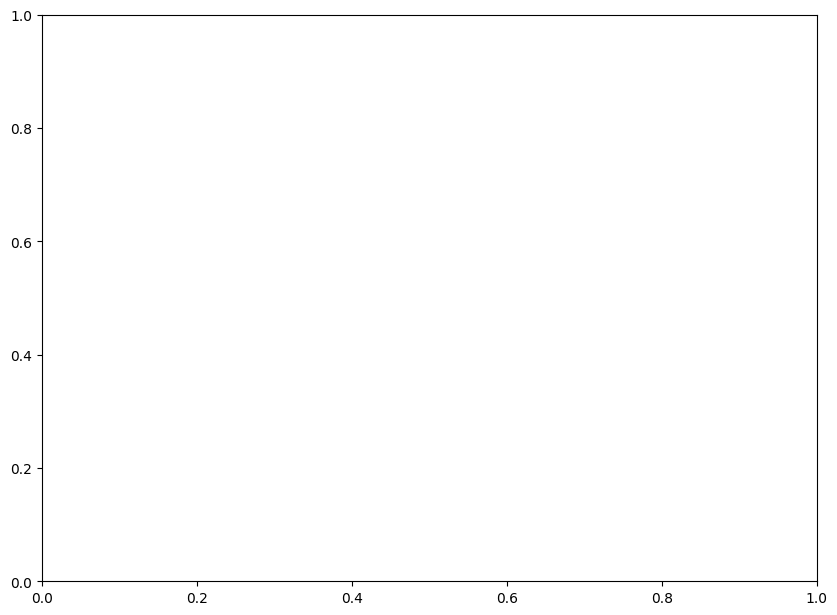

In [2]:
import tkinter as tk
from tkinter import ttk, messagebox
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from astropy.modeling import models, fitting
import pandas as pd
import os

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=10):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L-2, L))
    W = sparse.diags(np.ones(L), 0, shape=(L, L))
    
    for i in range(niter):
        Z = W + lam * (D.T @ D)
        b = W @ intensities
        print(f"Iteration {i+1}: Z shape = {Z.shape}, b shape = {b.shape}")
        try:
            z = spsolve(Z, b)
        except Exception as e:
            print(f"Warning: spsolve failed with error {e}. Trying alternative solver.")
            from scipy.sparse.linalg import lsmr
            z = lsmr(Z, b)[0]
        
        # Check for NaN or Inf
        if np.isnan(z).any() or np.isinf(z).any():
            print("Warning: NaN or Inf detected in baseline.")
        
        w = p * (intensities > z) + (1 - p) * (intensities < z)
        W = sparse.diags(w, 0, shape=(L, L))
    
    return z

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    try:
        conn = sqlite3.connect(db_name)
        query = """
            SELECT wavelength, intensity
            FROM spectrum_data
            WHERE sample_name = ? AND iteration = ?
            ORDER BY wavelength
        """
        cursor = conn.cursor()
        cursor.execute(query, (sample_name, iteration))
        results = cursor.fetchall()
        conn.close()
        if results:
            wavelengths, intensities = zip(*results)
            return np.array(wavelengths), np.array(intensities)
        else:
            return None, None
    except Exception as e:
        messagebox.showerror("Database Error", f"Error loading data: {e}")
        return None, None

# Function to fit Voigt profiles and calculate FWHM
def fit_voigt_profiles(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gauss):
    fitter = fitting.LevMarLSQFitter()
    models_list = []
    for idx in peak_indices:
        x0 = wavelengths[idx]
        amplitude = intensities[idx]
        voigt_init = models.Voigt1D(x_0=x0, amplitude_L=amplitude, fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gauss)
        # Define fitting range around the peak
        mask = (wavelengths > x0 - 1.0) & (wavelengths < x0 + 1.0)
        fit_wavelengths = wavelengths[mask]
        fit_intensities = intensities[mask]
        # Fit the model
        try:
            voigt_fit = fitter(voigt_init, fit_wavelengths, fit_intensities)
            fit_info = fitter.fit_info.copy()
            models_list.append((voigt_fit, fit_wavelengths, fit_intensities, fit_info))
        except Exception as e:
            print(f"Warning: Fitting failed for peak at {x0:.4f} nm: {e}")
            continue
    return models_list

# Calculate FWHM of Voigt profile
def calculate_fwhm_voigt(voigt_model):
    # FWHM Voigt secara empiris
    gamma = voigt_model.fwhm_L.value / 2
    sigma = voigt_model.fwhm_G.value / (2 * np.sqrt(2 * np.log(2)))
    fwhm = 0.5346 * (2 * gamma) + np.sqrt(0.2166 * (2 * gamma)**2 + (2.355 * sigma)**2)
    return fwhm

# GUI Application
def main_app():
    global db_processed, ax, canvas, lambda_var, iteration_var, wavelength_min_var, wavelength_max_var
    global status_label, sample_var, fig
    global fwhm_lorentz_var, fwhm_gauss_var, height_threshold_var
    global peak_listbox, root, wavelengths, corrected_intensities, peaks

    db_processed = 'tanah_vulkanik.db'  # Pastikan database ini ada dan path-nya benar

    root = tk.Tk()
    root.title("Voigt Profile Fitting Application")

    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

    status_label = ttk.Label(control_frame, text="Input parameters and press 'Update Plot'.")
    status_label.pack(anchor=tk.W, pady=5)

    # Sample Selection
    ttk.Label(control_frame, text="Sample:").pack(anchor=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(control_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.pack(anchor=tk.W, fill=tk.X)

    # Iteration Selection
    ttk.Label(control_frame, text="Iteration:").pack(anchor=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(control_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.pack(anchor=tk.W, fill=tk.X)

    # Lambda (λ)
    ttk.Label(control_frame, text="Lambda (λ):").pack(anchor=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(control_frame, textvariable=lambda_var).pack(anchor=tk.W, fill=tk.X)

    # Wavelength Min
    ttk.Label(control_frame, text="Wavelength Min:").pack(anchor=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(control_frame, textvariable=wavelength_min_var).pack(anchor=tk.W, fill=tk.X)

    # Wavelength Max
    ttk.Label(control_frame, text="Wavelength Max:").pack(anchor=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(control_frame, textvariable=wavelength_max_var).pack(anchor=tk.W, fill=tk.X)

    # FWHM Lorentzian
    ttk.Label(control_frame, text="FWHM Lorentzian:").pack(anchor=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_lorentz_var).pack(anchor=tk.W, fill=tk.X)

    # FWHM Gaussian
    ttk.Label(control_frame, text="FWHM Gaussian:").pack(anchor=tk.W)
    fwhm_gauss_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=fwhm_gauss_var).pack(anchor=tk.W, fill=tk.X)

    # Peak Height Threshold
    ttk.Label(control_frame, text="Peak Height Threshold:").pack(anchor=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(control_frame, textvariable=height_threshold_var).pack(anchor=tk.W, fill=tk.X)

    # Update Plot Button
    update_button = ttk.Button(control_frame, text="Update Plot", command=update_plot)
    update_button.pack(anchor=tk.W, pady=5)

    # Peak Selection Listbox
    ttk.Label(control_frame, text="Select Peaks for Fitting:").pack(anchor=tk.W, pady=(10, 0))
    peak_listbox = tk.Listbox(control_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.pack(anchor=tk.W, fill=tk.X)

    # Perform Fitting Button
    fit_button = ttk.Button(control_frame, text="Perform Voigt Fitting", command=perform_fitting)
    fit_button.pack(anchor=tk.W, pady=5)

    # Export Results Button
    export_button = ttk.Button(control_frame, text="Export Fitting Results", command=export_fitting_results)
    export_button.pack(anchor=tk.W, pady=5)

    # Plot Frame
    plot_frame = ttk.Frame(root)
    plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    # Matplotlib Figure
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    root.mainloop()

def update_plot():
    global wavelengths, corrected_intensities, peaks

    try:
        lam = float(lambda_var.get())
        iteration = int(iteration_var.get())
        wavelength_min = float(wavelength_min_var.get())
        wavelength_max = float(wavelength_max_var.get())
        height_threshold = float(height_threshold_var.get())
        sample = sample_var.get()
    except ValueError as ve:
        messagebox.showerror("Input Error", f"Invalid input: {ve}")
        return

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None or intensities is None:
        status_label.config(text="Data not found for this iteration.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    if len(wavelengths) == 0:
        status_label.config(text="No data in this wavelength range.")
        return

    baseline = baseline_als(intensities, lam=lam, p=0.01, niter=10)
    corrected_intensities = intensities - baseline

    # Peak Detection
    peaks, properties = find_peaks(corrected_intensities, height=height_threshold, distance=5, prominence=0.01)

    if len(peaks) == 0:
        status_label.config(text="No peaks detected. Check detection parameters.")
        return

    # Plotting Corrected Intensities and Detected Peaks
    ax.clear()
    ax.plot(wavelengths, corrected_intensities, 'o', color='black', markersize=3, label='Corrected Intensities')
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], 'x', color='red', label='Detected Peaks')

    ax.set_title(f"Spectrum ({sample}, Iteration {iteration})")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text=f"{len(peaks)} peaks detected.")

    # Update Listbox with Detected Peaks
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

def perform_fitting():
    global wavelengths, corrected_intensities, peaks, df_fitting_results

    selected_indices = peak_listbox.curselection()
    if not selected_indices:
        status_label.config(text="No peaks selected for fitting.")
        return

    try:
        fwhm_lorentz = float(fwhm_lorentz_var.get())
        fwhm_gauss = float(fwhm_gauss_var.get())
    except ValueError as ve:
        messagebox.showerror("Input Error", f"Invalid FWHM values: {ve}")
        return

    peak_indices = [peaks[idx] for idx in selected_indices]

    models_list = fit_voigt_profiles(wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gauss)

    if not models_list:
        status_label.config(text="Fitting unsuccessful for selected peaks.")
        return

    # Plotting
    ax.clear()
    ax.plot(wavelengths, corrected_intensities, 'o', color='black', markersize=3, label='Corrected Intensities')

    fitting_results = []

    for i, (model, fit_wavelengths, fit_intensities, fit_info) in enumerate(models_list):
        # Periksa apakah fitting berhasil
        if 'success' in fit_info and not fit_info['success']:
            message = fit_info.get('message', 'No message')
            status_label.config(text=f"Fitting did not converge for Peak {i+1}: {message}")
            continue
        if not hasattr(model, 'amplitude_G'):
            status_label.config(text=f"Fitting failed for Peak {i+1}.")
            continue
        fwhm_voigt = calculate_fwhm_voigt(model)
        peak_label = f"Peak {i+1} FWHM={fwhm_voigt:.4f} nm"
        ax.plot(fit_wavelengths, model(fit_wavelengths), '-', label=peak_label)
        fitting_results.append({
            'Peak Number': i+1,
            'Peak Center': model.x_0.value,
            'Amplitude_L': model.amplitude_L.value,
            'Amplitude_G': model.amplitude_G.value,
            'FWHM_L': model.fwhm_L.value,
            'FWHM_G': model.fwhm_G.value,
            'FWHM_Voigt': fwhm_voigt
        })

    ax.set_title("Voigt Fitting Results")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()

    # Save fitting results to DataFrame
    if fitting_results:
        df_fitting_results = pd.DataFrame(fitting_results)
        status_label.config(text="Fitting completed. Click 'Export Fitting Results' to save data.")
    else:
        df_fitting_results = None
        status_label.config(text="Fitting completed, but no successful fits.")

def export_fitting_results():
    if 'df_fitting_results' not in globals() or df_fitting_results is None or df_fitting_results.empty:
        status_label.config(text="No fitting data to export.")
        return

    try:
        filename = f"voigt_fitting_results_{sample_var.get()}_{iteration_var.get()}.xlsx"
        df_fitting_results.to_excel(filename, index=False)
        status_label.config(text=f"Fitting results exported to {filename}")
    except Exception as e:
        messagebox.showerror("Export Error", f"Failed to export fitting results: {e}")

if __name__ == "__main__":
    main_app()

In [1]:
import os
import numpy as np
import sqlite3
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import plotly.colors as pc

# Kelas untuk mengambil data dari database dan Excel
class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_experimental_data(self, sample_name):
        try:
            conn = sqlite3.connect(self.db_spectrum)
            cursor = conn.cursor()
            query = """
                SELECT wavelength, intensity
                FROM processed_spectrum
                WHERE sample_name = ? AND wavelength BETWEEN 200 AND 900
                ORDER BY wavelength
            """
            cursor.execute(query, (sample_name,))
            data = cursor.fetchall()
            conn.close()

            if not data:
                print(f"No data found for sample: {sample_name}")
                return np.array([]), np.array([])

            wavelengths, intensities = zip(*data)
            return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)
        except sqlite3.Error as e:
            print(f"Error accessing database: {e}")
            return np.array([]), np.array([])

    def get_peak_data(self, sample_name):
        # Bangun nama file Excel dari nama sampel
        excel_file = f"{sample_name}.xlsx"
        try:
            df = pd.read_excel(excel_file)
            return df
        except FileNotFoundError:
            print(f"Excel file not found: {excel_file}")
            return pd.DataFrame()
        except Exception as e:
            print(f"Error reading Excel file: {e}")
            return pd.DataFrame()

# Inisialisasi aplikasi Dash
app = Dash(__name__)

# Instansi pengambil data
data_fetcher = DataFetcher(db_nist='data1.db', db_spectrum='processed_spectra.db')

# Layout aplikasi Dash
app.layout = html.Div([
    html.H1("Spectrum Analyzer", style={'textAlign': 'center'}),  # Header dengan gaya
    html.Div([
        dcc.Input(
            id='sample-name',
            type='text',
            placeholder='Enter Sample Name',
            style={'marginRight': '10px', 'padding': '10px', 'width': '30%'}
        ),
        dcc.Input(
            id='intensity-threshold',
            type='number',
            placeholder='Enter Intensity Threshold',
            min=0,
            style={'marginRight': '10px', 'padding': '10px', 'width': '20%'}
        ),
        dcc.Input(  # Input untuk localized_range
            id='localized-range',
            type='number',
            placeholder='Enter Localized Range (nm)',
            min=1,
            step=1,
            value=5,  # Nilai default
            style={'marginRight': '10px', 'padding': '10px', 'width': '20%'}
        ),
        html.Button(
            'Plot Spectrum',
            id='plot-button',
            n_clicks=0,
            style={'padding': '10px', 'backgroundColor': '#007BFF', 'color': 'white', 'border': 'none'}
        )
    ], style={'marginBottom': '20px', 'textAlign': 'center'}),  # Pengaturan layout untuk input

    dcc.Graph(
        id='spectrum-plot',
        config={
            'toImageButtonOptions': {
                'format': 'png',  # Format gambar ekspor (png, jpeg, pdf, svg)
                'filename': 'spectrum_plot',  # Nama file ekspor default
                'height': 600,  # Tinggi gambar dalam piksel
                'width': 900,  # Lebar gambar dalam piksel
                'scale': 10  # Skala resolusi gambar
            },
            'displaylogo': False,  # Sembunyikan logo Plotly di toolbar
            'modeBarButtonsToAdd': [
                'drawline', 'drawopenpath', 'drawcircle', 'eraseshape'  # Tambahkan alat tambahan
            ],
            'modeBarButtonsToRemove': [
                'zoom2d', 'pan2d', 'select2d', 'lasso2d'  # Hapus alat yang tidak dibutuhkan
            ],
            'scrollZoom': True  # Aktifkan zoom dengan scroll mouse
        },
        style={'height': '600px', 'width': '900', 'margin': '0 auto'}  # Atur ukuran grafik dan posisi
    )
], style={'fontFamily': 'Arial, sans-serif', 'padding': '20px'})  # Tambahkan gaya umum

# Callback untuk memperbarui plot
@app.callback(
    Output('spectrum-plot', 'figure'),
    Input('plot-button', 'n_clicks'),
    Input('sample-name', 'value'),
    Input('intensity-threshold', 'value'),
    Input('localized-range', 'value')  # Input untuk localized_range
)
def update_plot(n_clicks, sample_name, intensity_threshold, localized_range):
    if n_clicks > 0 and sample_name and localized_range:  # Pastikan localized_range valid
        # Ambil data eksperimental
        exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample_name)
        if exp_wavelengths.size == 0:
            return go.Figure()  # Kembalikan figure kosong jika tidak ada data

        # Ambil data puncak dari file Excel terkait
        df = data_fetcher.get_peak_data(sample_name)
        if df.empty:
            return go.Figure()  # Kembalikan figure kosong jika file Excel tidak ditemukan
        exp_peak_wl = df['Exp Peak WL'].dropna().values
        exp_intensity = df['Exp Intensity'].dropna().values
        elements = df['Element'].dropna().values
        ion_stages = df['Ion Stage'].dropna().values

        # Menyaring data puncak berdasarkan intensitas threshold
        if intensity_threshold is not None:
            filtered_peaks = [(wl, intensity, element, ion_stage)
                              for wl, intensity, element, ion_stage in
                              zip(exp_peak_wl, exp_intensity, elements, ion_stages)
                              if intensity >= intensity_threshold]
        else:
            filtered_peaks = zip(exp_peak_wl, exp_intensity, elements, ion_stages)

        # Kelompokkan puncak berdasarkan elemen ion dalam rentang localized_range
        grouped_labels = {}
        for wl, intensity, element, ion_stage in filtered_peaks:
            # Tentukan kunci grup berdasarkan elemen dan ion stage
            key = (element, ion_stage, int(wl // localized_range * localized_range))
            if key not in grouped_labels:
                grouped_labels[key] = {}

            # Tambahkan panjang gelombang dan intensitas jika WL belum ada
            rounded_wl = round(wl, 2)  # Pembulatan hingga dua desimal
            if rounded_wl not in grouped_labels[key]:
                grouped_labels[key][rounded_wl] = intensity

        # Buat figure baru
        fig = go.Figure()

        # Tambahkan data eksperimental dengan garis hitam
        fig.add_trace(go.Scatter(x=exp_wavelengths, y=exp_intensities,
                                 mode='lines', name='Experimental Data',
                                 line=dict(color='black')))

        # Tentukan warna otomatis berdasarkan elemen ion
        unique_elements = sorted(set(elements))  # Dapatkan elemen ion yang unik
        colors = pc.qualitative.Set1  # Gunakan palet warna

        # Buat pemetaan elemen ke warna
        element_colors = {element: colors[i % len(colors)]
                          for i, element in enumerate(unique_elements)}

        # Tambahkan anotasi dan garis untuk setiap grup
        for (element, ion_stage, wl_group), peaks in grouped_labels.items():
            # Ambil semua panjang gelombang dan intensitas untuk grup ini
            wavelengths = list(peaks.keys())
            intensities = list(peaks.values())

            # Hitung rata-rata panjang gelombang dan intensitas
            avg_wl = np.mean(wavelengths)
            avg_intensity = np.mean(intensities)

            # Buat label untuk elemen dan ion stage
            ion_stage_roman = f"{['I', 'II', 'III', 'IV', 'V'][ion_stage-1]}" if ion_stage <= 5 else f"{ion_stage}"
            label_text = f"<b>{element} {ion_stage_roman}</b> " + ", ".join(f"{wl:.2f}" for wl in sorted(wavelengths)) + " nm"

            # Tambahkan anotasi untuk grup yang digabung
            fig.add_annotation(
                x=avg_wl,
                y=avg_intensity + 0.1,  # Posisi Y di atas rata-rata intensitas
                text=label_text,
                showarrow=False,
                font=dict(size=12),
                bgcolor="rgba(0,0,0,0)",  # Warna latar belakang label
                bordercolor="black",
                borderwidth=0,
                borderpad=4,
                opacity=1,
                textangle=-90,  # Rotasi teks 90 derajat
                xanchor="center",  # Jangkar teks di tengah
                yanchor="bottom"
            )

            # Tambahkan garis dari label grup ke setiap puncak
            for wl, intensity in peaks.items():
                fig.add_trace(go.Scatter(
                    x=[avg_wl, wl],
                    y=[avg_intensity + 0.1, intensity],
                    mode='lines',
                    line=dict(color=element_colors[element], width=0.7, dash='dash'),
                    showlegend=False,
                    hoverinfo='text',
                    text=f"{element}<br>Wavelength: {wl:.2f} nm<br>Intensity: {intensity:.2f}"
                ))


        # Setel rentang sumbu y
        fig.update_yaxes(range=[0, 1.2 * max(exp_intensities)])

        # Perbarui layout
        fig.update_layout(
            xaxis_title='Wavelength (nm)',
            yaxis_title='Normalized Intensity (a.u.)',
            plot_bgcolor='rgba(255,255,255,1)',
            paper_bgcolor='rgba(255,255,255,1)',
            showlegend=False,
            margin=dict(l=50, r=50, t=50, b=50),
            xaxis=dict(showline=True, linewidth=1, linecolor='black'),
            yaxis=dict(showline=True, linewidth=1, linecolor='black')
        )

        return fig
    return go.Figure()

if __name__ == '__main__':
    app.run_server(debug=True)


NameError: name 'true' is not defined